In [20]:
import sys
sys.path.append("/home/luca/Desktop/CM/CM/")
sys.path.append("../../")

import numpy as np
from Network import NR, NC
import src.utils as utils
from matplotlib import pyplot as plt


def plot_stats(conf, dataset, test, net, save=False, log=True):
    print(conf)
    net.plot_results(f"{dataset}_{test}_loss", score=False, save=save, log=log)
    net.plot_results(f"{dataset}_{test}_loss", score=False, save=save, time=True, log=log)
    net.plot_results(f"{dataset}_{test}_score", score=True, save=save, log=log)
    net.plot_results(f"{dataset}_{test}_score", score=True, save=save, time=True, log=log)

    net.plot_grad(f"{dataset}_{test}", save=save)
    print(net.best_score())


def plot_comparison(x_datas, y_datas, x_label, y_label, title, loc='best', yscale='log'):
    plt.plot(x_datas[0], y_datas[0], linewidth=2., label='(A1/cm)')
    plt.yscale(yscale)
    plt.grid(True, 'major', 'both', linewidth=0.3)

    plt.plot(x_datas[1], y_datas[1], linewidth=2., label='(A1/nag)')
    plt.yscale(yscale)

    plt.plot(x_datas[2], y_datas[2], linewidth=2., label='(A2)')
    plt.yscale(yscale)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc=loc, fontsize=13)
    plt.title(title)
    plt.show()
    plt.clf()
    

def report_plots(params, dataset, net_SGD, net_SGD_nest, net_Adam, score=False):

    # Conditional configuration
    x_label_time = 'Execution Time'
    x_label_ep = 'Epochs'
    curve_type = 'Objective function' if not score else 'Score'
    title = curve_type + ' comparison - ' + dataset

    train_res_SGD = net_SGD.train_scores if score else net_SGD.train_loss
    train_res_SGD_nest = net_SGD_nest.train_scores if score else net_SGD_nest.train_loss
    train_res_Adam = net_Adam.train_scores if score else net_Adam.train_loss
    x_SGD_time = net_SGD.epochs_time
    x_SGD_ep = list(range(len(train_res_SGD)))
    x_SGD_nest_time = net_SGD_nest.epochs_time
    x_SGD_nest_ep = list(range(len(train_res_SGD_nest)))
    x_Adam_time = net_Adam.epochs_time
    x_Adam_ep = list(range(len(train_res_Adam)))

    plot_comparison([x_SGD_time, x_SGD_nest_time, x_Adam_time], 
                  [train_res_SGD, train_res_SGD_nest, train_res_Adam],
                  x_label_time, 
                  curve_type, 
                  title
                 )
    
    plot_comparison([x_SGD_ep, x_SGD_nest_ep, x_Adam_ep], 
                  [train_res_SGD, train_res_SGD_nest, train_res_Adam],
                  x_label_ep, 
                  curve_type, 
                  title
                 )
    
    plot_comparison([x_SGD_ep, x_SGD_nest_ep, x_Adam_ep], 
                  [net_SGD.grad_est_per_epoch, net_SGD_nest.grad_est_per_epoch, net_Adam.grad_est_per_epoch],
                  x_label_ep, 
                  'Gradient norm', 
                  f'Gradient norm comparison - {dataset}',
                  1
                 )

def report_stats(params, dataset, score=False, debug=False):
    if dataset == 'cup':
        nn = NR
        X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset])
    else:
        X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
        nn = NC


    # --- MODEL CONFIGURATIONS ---
    param_SGD = params[dataset]['sgd'].copy()
    param_SGD_nest = params[dataset]['sgd'].copy()
    param_Adam = params[dataset]['adam'].copy()
    
    param_SGD['verbose'] = debug
    net_SGD_eval = nn(**param_SGD)
    net_SGD = nn(**param_SGD)

    param_SGD_nest['verbose'] = debug
    param_SGD_nest['nesterovs_momentum'] = True
    net_SGD_nest_eval = nn(**param_SGD_nest)
    net_SGD_nest = nn(**param_SGD_nest)

    param_Adam['verbose'] = debug
    net_Adam_eval = nn(**param_Adam)    
    net_Adam = nn(**param_Adam)   
    # --- MODEL CONFIGURATIONS --- 

    # Train and print best results with given configurations
    net_SGD_eval.fit(X_train, y_train, test_data=(X_test, y_test))
    net_SGD.fit(X_train, y_train, test_data=(X_test, y_test), f_star_set=net_SGD_eval.f_star, grad_star=net_SGD_eval.grad_star)
    net_SGD_nest_eval.fit(X_train, y_train, test_data=(X_test, y_test))
    net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test), f_star_set=net_SGD_nest_eval.f_star, grad_star=net_SGD_nest_eval.grad_star)
    net_Adam_eval.fit(X_train, y_train, test_data=(X_test, y_test))
    net_Adam.fit(X_train, y_train, test_data=(X_test, y_test), f_star_set=net_Adam_eval.f_star, grad_star=net_Adam_eval.grad_star)

    print("----- SGD -----")
    print(param_SGD)
    print(net_SGD.best_score(),"\n")
    
    print("----- SGD nesterov-----")
    print(param_SGD_nest)
    print(net_SGD_nest.best_score(),"\n")

    print("----- Adam -----")
    print(param_Adam)
    print(net_Adam.best_score(),"\n")

    return net_SGD, net_SGD_nest, net_Adam


def report_gap_rate(dataset, net_SGD, net_SGD_nest, net_Adam, save=False):
    solver = '(A1/cm)'
    plot_name = f"{dataset}_{solver}"
    net_SGD.plot_gap(dataset, solver, save=save)
    net_SGD.plot_rate(plot_name, save=save)

    solver = '(A1/nag)'
    plot_name = f"{dataset}_{solver}"
    net_SGD_nest.plot_gap(dataset, solver, save=save)
    net_SGD_nest.plot_rate(plot_name, save=save)

    solver = '(A2)'
    plot_name = f"{dataset}_{solver}"
    net_Adam.plot_gap(dataset, solver, save=save)
    net_Adam.plot_rate(plot_name, save=save)


def report_gap_comp(dataset, net_SGD, net_SGD_nest, net_Adam, save=False):
    max_epochs = np.max([len(net_SGD.gap), len(net_SGD_nest.gap), len(net_Adam.gap)])
    epochs = range(max_epochs)

    plot_comparison([epochs, epochs, epochs],
        [net_SGD.gap, net_SGD_nest.gap, net_Adam.gap],
        'Epochs',
        'gap term',
        'Objective function gap comparison - ' + dataset)

    plot_comparison([epochs, epochs, epochs],
        [net_SGD.grad_gap, net_SGD_nest.grad_gap, net_Adam.grad_gap],
        'Epochs',
        'gap term',
        'Gradient gap comparison - ' + dataset)

    plot_comparison([epochs[1:], epochs[1:], epochs[1:]],
        [net_SGD.grad_rate, net_SGD_nest.grad_rate, net_Adam.grad_rate],
        'Epochs',
        'rate',
        'Gradient rate comparison - ' + dataset)

In [30]:
datasets = {
    'cup': '../../data/ML-CUP20-TR.csv',
    'monk1': '../../data/monks-1',
    'monk2': '../../data/monks-2', 
    'monk3': '../../data/monks-3', 
}

params = {
    'cup': {
        'sgd': {
            'activation': 'logistic',
            'alpha': 0.3,
            'batch_size': None,
            'hidden_layer_sizes': [5, 10],
            'learning_rate_init': 0.01,
            'max_iter': 10000,
            'momentum': 0.5,
            'solver': 'sgd',
            'tol': 1e-08
        },
        'adam': {
            'activation': 'logistic',
            'alpha': 0.3,
            'batch_size': None,
            'hidden_layer_sizes': [5, 10],
            'learning_rate_init': 0.005,
            'max_iter': 10000,
            'solver': 'adam',
            'tol': 1e-08
        }
    },
    'monk1': {
        'sgd': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': 10,
            'hidden_layer_sizes': [3, 5],
            'learning_rate_init': 0.005,
            'max_iter': 10000,
            'momentum': 0.9,
            'nesterovs_momentum': False,
            'solver': 'sgd',
            'tol': 1e-06
        },
        'adam': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': None,
            'hidden_layer_sizes': [3,5],
            'learning_rate_init': 0.001,
            'max_iter': 10000,
            'solver': "adam",
            'tol': 1e-6,
        }
    },
    'monk2': {
        'sgd': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': 10,
            'hidden_layer_sizes': [3, 5],
            'learning_rate_init': 0.1,
            'max_iter': 10000,
            'momentum': 0.5,
            'nesterovs_momentum': False,
            'solver': 'sgd',
            'tol': 1e-06
        },
        'adam': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': None,
            'hidden_layer_sizes': [3, 5],
            'learning_rate_init': 0.005,
            'max_iter': 10000,
            'solver': 'adam',
            'tol': 1e-6
        }
    },
    'monk3': {
        'sgd': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': None,
            'hidden_layer_sizes': [2, 3],
            'learning_rate_init': 0.1,
            'max_iter': 10000,
            'momentum': 0.5,
            'nesterovs_momentum': False,
            'solver': 'sgd',
            'tol': 1e-06
        },
        'adam': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': None,
            'hidden_layer_sizes': [2, 3],
            'learning_rate_init': 0.001,
            'max_iter': 10000,
            'solver': 'adam',
            'tol': 1e-6
        }
    }
}

## Testing configuration

### Monk1

In [3]:
dataset = 'monk1'
epochs = 4000

sgd_cm = params[dataset]['sgd'].copy()
sgd_cm['max_iter'] = epochs

sgd_nag = sgd_cm.copy()
sgd_nag['nesterovs_momentum'] = True
sgd_nag['max_iter'] = epochs

adam = params[dataset]['adam'].copy()
adam['max_iter'] = epochs

monk1 = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}
    
X_train, X_test, y_train, y_test = utils.load_monk(datasets['monk1'])
nn = NC
    
net_SGD = nn(**monk1['SGD'])
net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD_nest = nn(**monk1['SGD_nest'])
net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))

net_Adam = nn(**monk1['Adam'])
net_Adam.fit(X_train, y_train, test_data=(X_test, y_test))

NC(alpha=0.001, batch_size=10, hidden_layer_sizes=[3, 5],
   learning_rate_init=0.001, max_iter=4000, solver='adam', tol=1e-06)

----- SGD CM -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.005, 'max_iter': 4000, 'momentum': 0.9, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06}


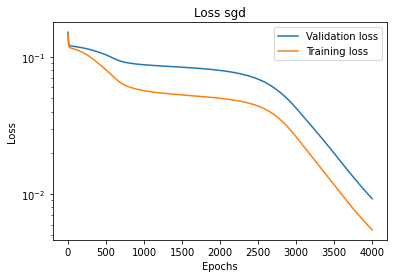

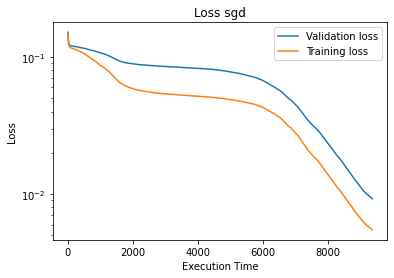

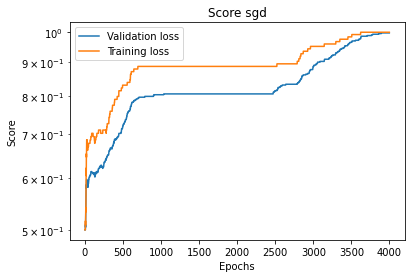

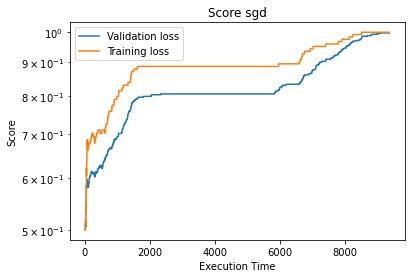

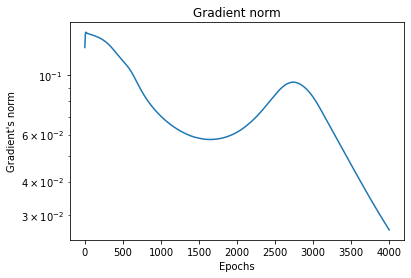

ep: 4000    | s: [3, 5] | b: 10 | e:0.005 | alpha:0.001 | m:  0.9 | nesterovs_momentum: False
Grad: 2.63578e-02 | Loss: 9.25499e-03, 5.47935e-03 | Score: 0.998, 1    
ended in: 9372.516, avg per ep: 2.343129
total update: 7869.522000000003, avg updt: 0.16394837500000006
total ff: 60000, total ff time: 1917.7209999992176, avg ff: 0.031962016666653624
total bp: 52000, total bp time: 3643.115999999798, avg bp: 0.07005992307691919
total ev: 4000, total ev time: 1333.5680000000034, avg ev: 0.33339200000000085


----- SGD NAG -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.005, 'max_iter': 4000, 'momentum': 0.9, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1e-06}


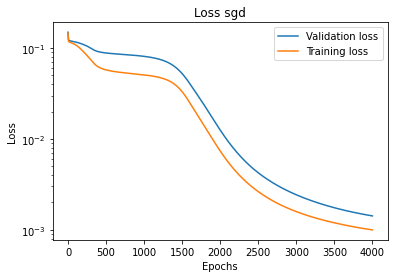

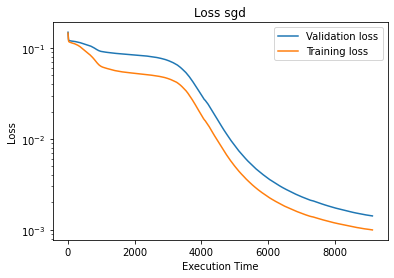

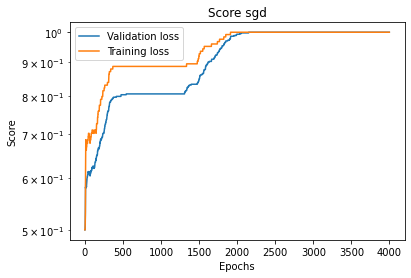

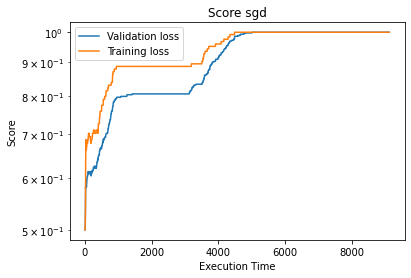

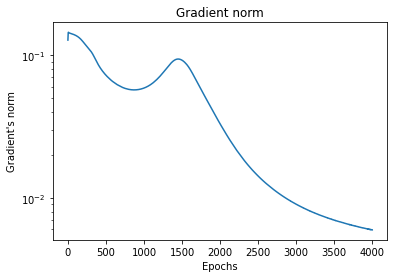

ep: 4000    | s: [3, 5] | b: 10 | e:0.005 | alpha:0.001 | m:  0.9 | nesterovs_momentum: True
Grad: 5.95552e-03 | Loss: 1.42126e-03, 9.96805e-04 | Score:     1, 1    
ended in: 9127.326, avg per ep: 2.2818314999999996
total update: 7794.44199999998, avg updt: 0.16238420833333292
total ff: 60000, total ff time: 1774.9239999992878, avg ff: 0.029582066666654798
total bp: 52000, total bp time: 3411.7289999998416, avg bp: 0.06561017307692003
total ev: 4000, total ev time: 1196.081, avg ev: 0.29902025


----- Adam -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.001, 'max_iter': 4000, 'solver': 'adam', 'tol': 1e-06}


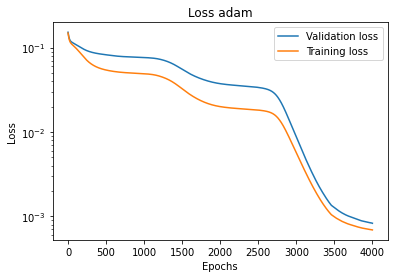

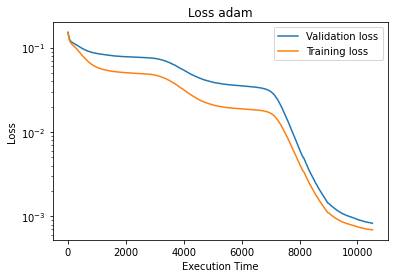

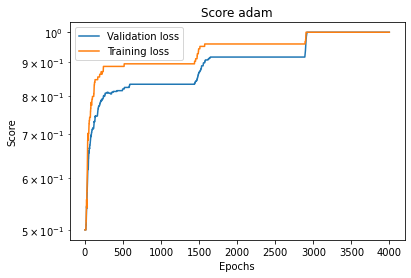

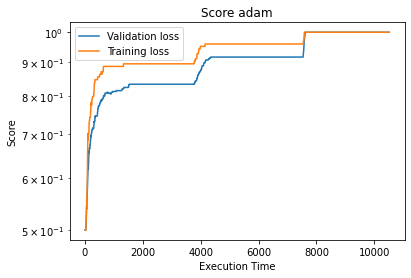

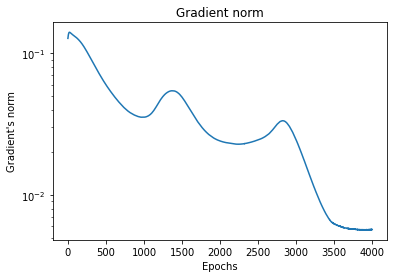

ep: 4000    | s: [3, 5] | b: 10 | e:0.001 | alpha:0.001 | m:  0.5 | nesterovs_momentum: False
Grad: 5.70396e-03 | Loss: 8.29880e-04, 6.91963e-04 | Score:     1, 1    
ended in: 10518.24, avg per ep: 2.62956
total update: 9197.500999999986, avg updt: 0.19161460416666637
total ff: 60000, total ff time: 1807.0009999991094, avg ff: 0.03011668333331849
total bp: 52000, total bp time: 3375.2979999998947, avg bp: 0.0649095769230749
total ev: 4000, total ev time: 1189.5600000000054, avg ev: 0.2973900000000014




<Figure size 432x288 with 0 Axes>

In [4]:
print("----- SGD CM -----")
plot_stats(sgd_cm, dataset, 'SGD', net_SGD)
print("----- SGD NAG -----")
plot_stats(sgd_nag, dataset, 'SGD', net_SGD_nest)
print("----- Adam -----")
plot_stats(adam, dataset, 'Adam', net_Adam)

### Monk2

In [ ]:
dataset = 'monk2'
epochs = 4000

sgd_cm = params[dataset]['sgd'].copy()
sgd_cm['max_iter'] = epochs

sgd_nag = sgd_cm.copy()
sgd_nag['nesterovs_momentum'] = True
sgd_nag['max_iter'] = epochs

adam = params[dataset]['adam'].copy()
adam['max_iter'] = epochs

monk2 = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}
    
X_train, X_test, y_train, y_test = utils.load_monk(datasets['monk2'])
nn = NC
    
net_SGD = nn(**monk2['SGD'])
net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD_nest = nn(**monk2['SGD_nest'])
net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))

net_Adam = nn(**monk2['Adam'])
net_Adam.fit(X_train, y_train, test_data=(X_test, y_test))

NC(alpha=0, batch_size=10, hidden_layer_sizes=[3, 5], max_iter=4000,
   solver='adam', tol=1e-12)

----- SGD CM -----
{'activation': 'logistic', 'alpha': 0, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.1, 'max_iter': 4000, 'momentum': 0.8, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06}


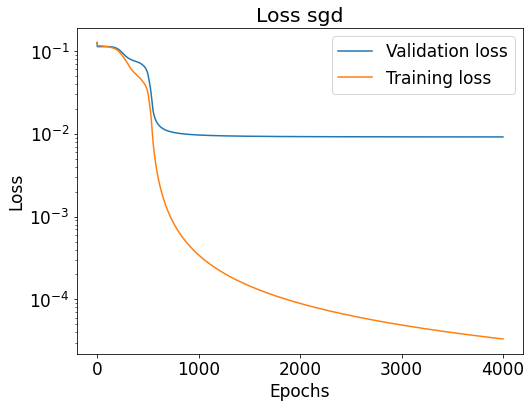

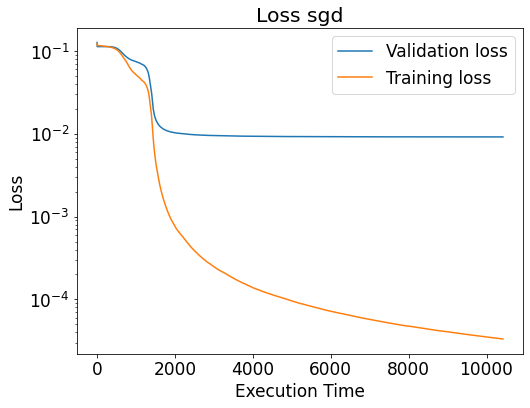

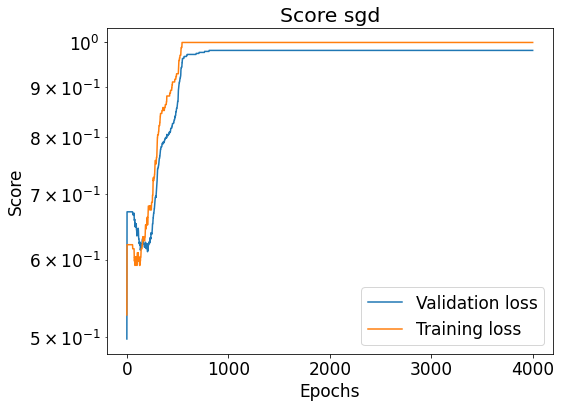

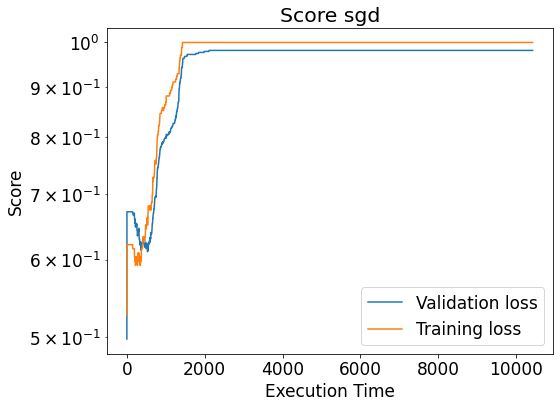

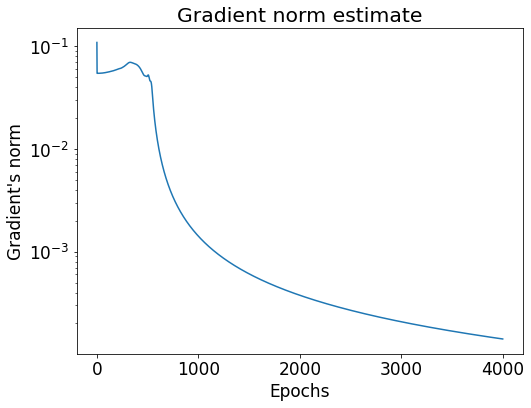

ep: 4000    | s: [3, 5] | b: 10 | e:  0.1 | alpha:    0 | m:  0.8 | nesterovs_momentum: False
Grad: 2.54636e-04 | Loss: 9.15942e-03, 3.32848e-05 | Score: 0.981, 1    
ended in: 10421.202, avg per ep: 2.6053005
total update: 9240.854000000027, avg updt: 2.310213500000007
total ff: 76000, total ff time: 2180.1909999989516, avg ff: 0.02868672368419673
total bp: 68000, total bp time: 4348.1269999998885, avg bp: 0.06394304411764543
total ev: 4000, total ev time: 1074.1010000000033, avg ev: 0.2685252500000008


----- SGD NAG -----
{'activation': 'logistic', 'alpha': 0, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.1, 'max_iter': 4000, 'momentum': 0.8, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1e-06}


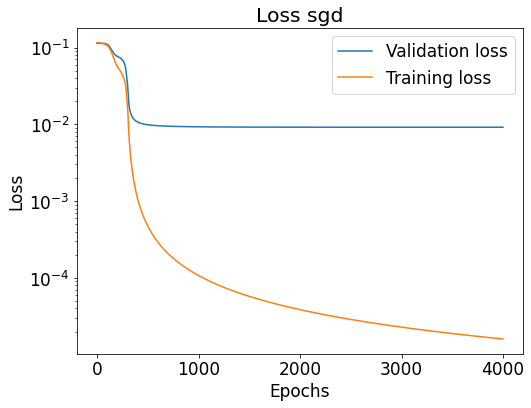

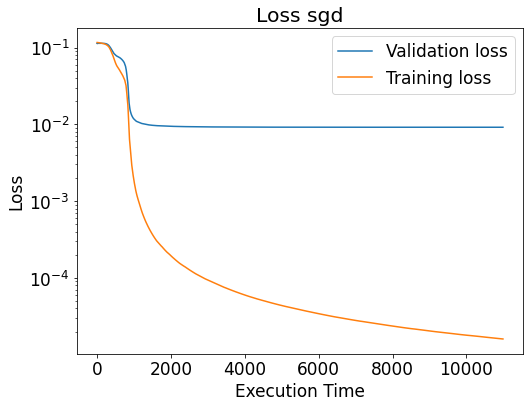

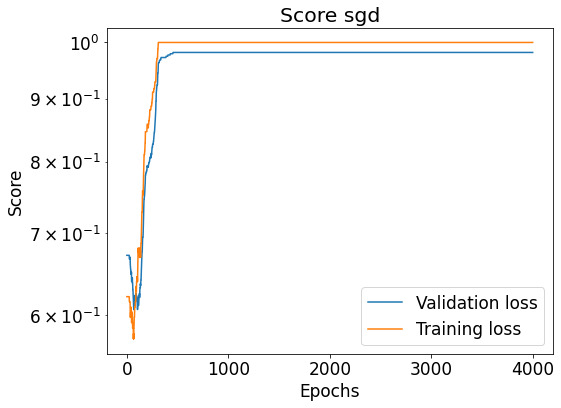

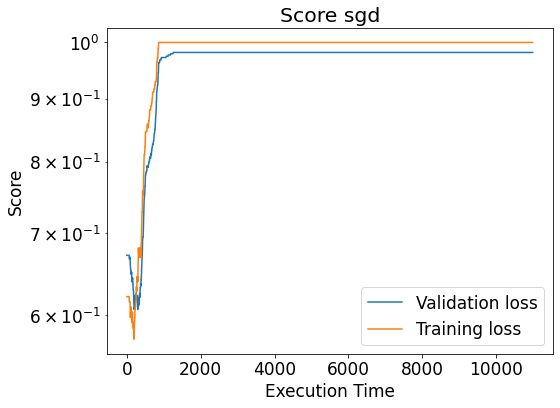

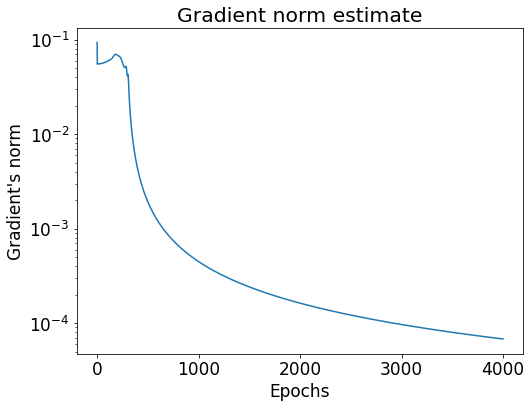

ep: 4000    | s: [3, 5] | b: 10 | e:  0.1 | alpha:    0 | m:  0.8 | nesterovs_momentum: True
Grad: 1.22827e-04 | Loss: 9.16134e-03, 1.93923e-05 | Score: 0.981, 1    
ended in: 10989.457, avg per ep: 2.74736425
total update: 9830.284999999982, avg updt: 2.4575712499999955
total ff: 76000, total ff time: 2158.2889999989134, avg ff: 0.028398539473669913
total bp: 68000, total bp time: 4257.242999999869, avg bp: 0.06260651470588044
total ev: 4000, total ev time: 1054.711000000004, avg ev: 0.26367775000000104


----- Adam -----
{'activation': 'logistic', 'alpha': 0, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.1, 'max_iter': 4000, 'solver': 'adam', 'tol': 1e-12}


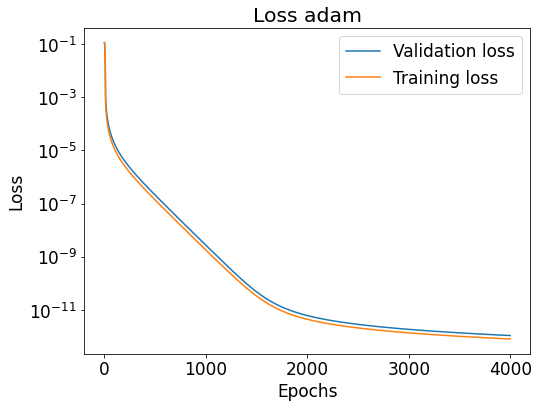

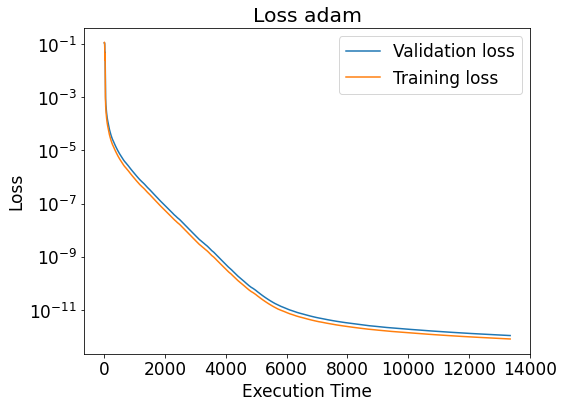

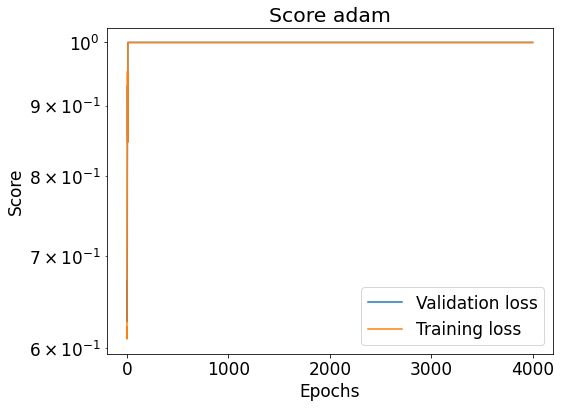

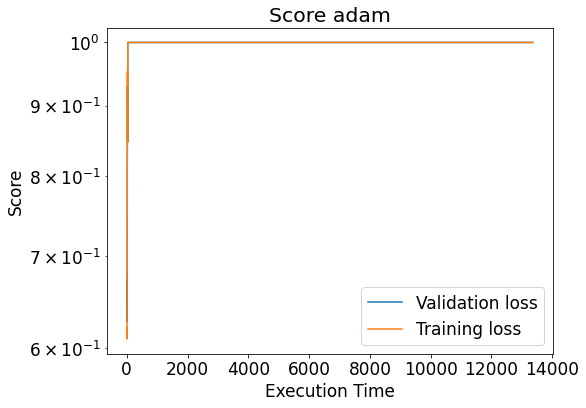

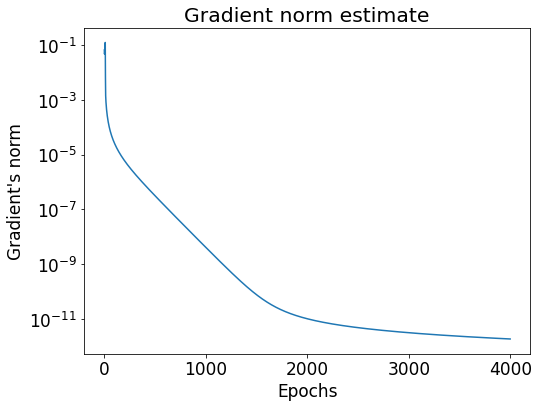

ep: 4000    | s: [3, 5] | b: 10 | e:  0.1 | alpha:    0 | m:  0.5 | nesterovs_momentum: False
Grad: 2.86899e-12 | Loss: 1.09534e-12, 8.13923e-13 | Score:     1, 1    
ended in: 13355.643, avg per ep: 3.33891075
total update: 12191.260000000033, avg updt: 3.0478150000000084
total ff: 76000, total ff time: 2213.3239999990533, avg ff: 0.02912268421051386
total bp: 68000, total bp time: 4442.326999998092, avg bp: 0.06532833823526606
total ev: 4000, total ev time: 1056.859000000001, avg ev: 0.2642147500000003




<Figure size 576x432 with 0 Axes>

In [ ]:
print("----- SGD CM -----")
plot_stats(sgd_cm, dataset, 'SGD', net_SGD)
print("----- SGD NAG -----")
plot_stats(sgd_nag, dataset, 'SGD', net_SGD_nest)
print("----- Adam -----")
plot_stats(adam, dataset, 'Adam', net_Adam)

### Monk3

In [ ]:
dataset = 'monk3'
epochs = 4000

sgd_cm = params[dataset]['sgd'].copy()
sgd_cm['max_iter'] = epochs

sgd_nag = sgd_cm.copy()
sgd_nag['nesterovs_momentum'] = True
sgd_nag['max_iter'] = epochs

adam = params[dataset]['adam'].copy()
adam['max_iter'] = epochs

monk3 = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}
    
X_train, X_test, y_train, y_test = utils.load_monk(datasets['monk3'])
nn = NC
    
net_SGD = nn(**monk3['SGD'])
net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD_nest = nn(**monk3['SGD_nest'])
net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))

net_Adam = nn(**monk3['Adam'])
net_Adam.fit(X_train, y_train, test_data=(X_test, y_test))

NC(alpha=0.1, batch_size=32, hidden_layer_sizes=[2, 3],
   learning_rate_init=0.005, max_iter=4000, solver='adam', tol=1e-12)

----- SGD CM -----
{'activation': 'logistic', 'alpha': 0.1, 'batch_size': 32, 'hidden_layer_sizes': [2, 3], 'learning_rate_init': 0.1, 'max_iter': 4000, 'momentum': 0.8, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06}


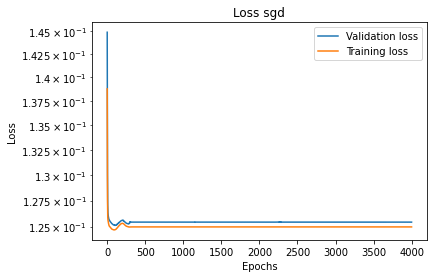

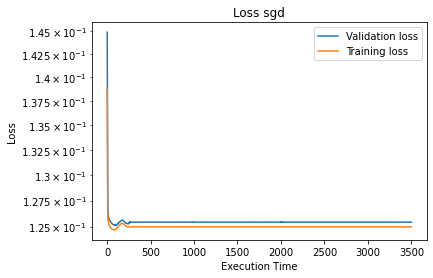

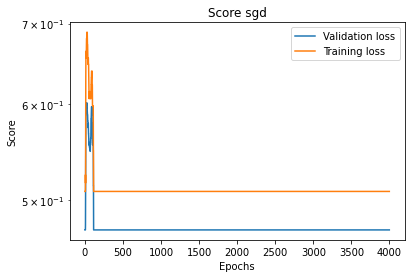

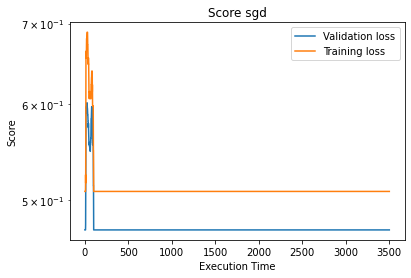

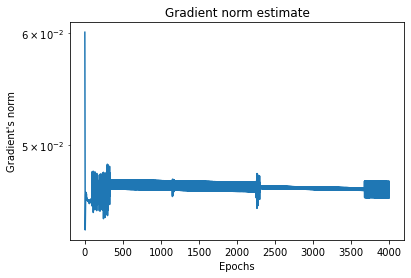

ep: 4000    | s: [2, 3] | b: 32 | e:  0.1 | alpha:  0.1 | m:  0.8 | nesterovs_momentum: False
Grad: 3.43946e-02 | Loss: 1.25120e-01, 1.24726e-01 | Score: 0.602, 0.689
ended in: 3502.275, avg per ep: 0.87556875
total update: 2437.958999999992, avg updt: 0.609489749999998
total ff: 24000, total ff time: 880.7590000000167, avg ff: 0.03669829166666736
total bp: 16000, total bp time: 1127.876999999976, avg bp: 0.0704923124999985
total ev: 4000, total ev time: 970.9770000000005, avg ev: 0.24274425000000013


----- SGD NAG -----
{'activation': 'logistic', 'alpha': 0.1, 'batch_size': 32, 'hidden_layer_sizes': [2, 3], 'learning_rate_init': 0.1, 'max_iter': 4000, 'momentum': 0.8, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1e-06}


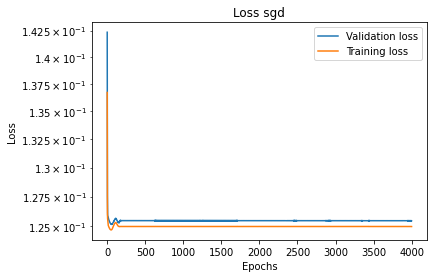

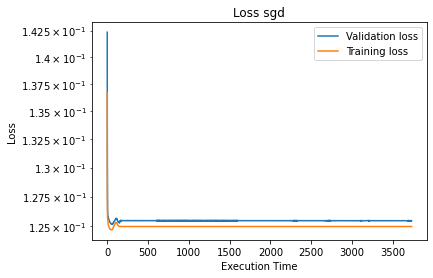

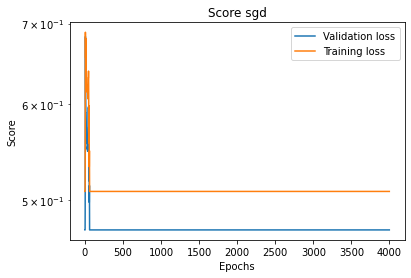

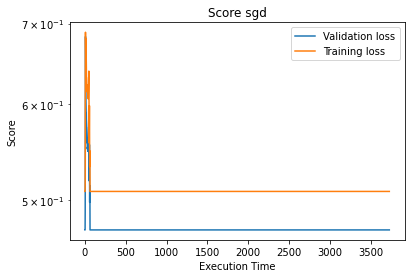

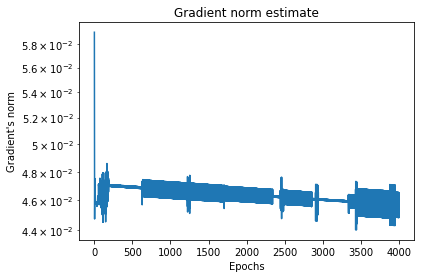

ep: 4000    | s: [2, 3] | b: 32 | e:  0.1 | alpha:  0.1 | m:  0.8 | nesterovs_momentum: True
Grad: 3.21481e-02 | Loss: 1.25157e-01, 1.24721e-01 | Score: 0.683, 0.689
ended in: 3729.698, avg per ep: 0.9324245
total update: 2659.165000000002, avg updt: 0.6647912500000005
total ff: 24000, total ff time: 886.3800000000023, avg ff: 0.0369325000000001
total bp: 16000, total bp time: 1145.5209999999195, avg bp: 0.07159506249999496
total ev: 4000, total ev time: 976.7329999999955, avg ev: 0.24418324999999888


----- Adam -----
{'activation': 'logistic', 'alpha': 0.1, 'batch_size': 32, 'hidden_layer_sizes': [2, 3], 'learning_rate_init': 0.005, 'max_iter': 4000, 'solver': 'adam', 'tol': 1e-12}


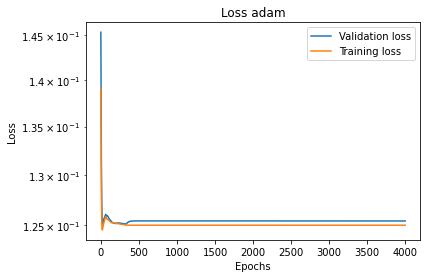

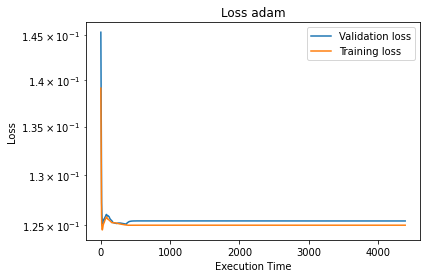

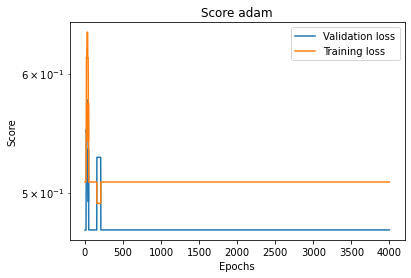

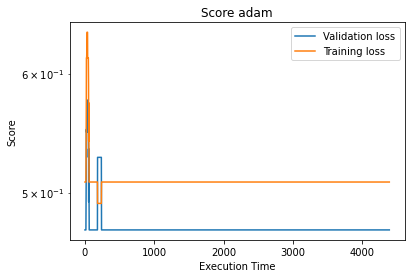

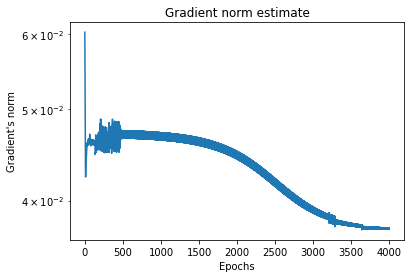

ep: 4000    | s: [2, 3] | b: 32 | e:0.005 | alpha:  0.1 | m:  0.5 | nesterovs_momentum: False
Grad: 2.99537e-02 | Loss: 1.25075e-01, 1.24985e-01 | Score: 0.576, 0.639
ended in: 4390.508, avg per ep: 1.097627
total update: 3294.982000000017, avg updt: 0.8237455000000042
total ff: 24000, total ff time: 913.1809999999274, avg ff: 0.03804920833333031
total bp: 16000, total bp time: 1175.0679999999456, avg bp: 0.0734417499999966
total ev: 4000, total ev time: 997.2409999999943, avg ev: 0.24931024999999857




<Figure size 432x288 with 0 Axes>

In [ ]:
print("----- SGD CM -----")
plot_stats(sgd_cm, dataset, 'SGD', net_SGD)
print("----- SGD NAG -----")
plot_stats(sgd_nag, dataset, 'SGD', net_SGD_nest)
print("----- Adam -----")
plot_stats(adam, dataset, 'Adam', net_Adam)

### CUP

In [6]:
dataset = 'cup'

sgd_cm = params[dataset]['sgd'].copy()
sgd_nag = sgd_cm.copy()
sgd_nag['nesterovs_momentum'] = True
adam = params[dataset]['adam'].copy()

cup = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}
    
X_train, X_test, y_train, y_test = utils.load_CUP(datasets['cup'])
nn = NR
    
net_SGD = nn(**cup['SGD'])
net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD_nest = nn(**cup['SGD_nest'])
net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))

net_Adam = nn(**cup['Adam'])
net_Adam.fit(X_train, y_train, test_data=(X_test, y_test))

NR(alpha=0.3, batch_size=1033, hidden_layer_sizes=[5, 10],
   learning_rate_init=0.02, max_iter=10000, solver='adam', tol=1e-08)

----- SGD CM -----
{'activation': 'logistic', 'alpha': 0.2, 'batch_size': 128, 'hidden_layer_sizes': [5, 10], 'learning_rate_init': 0.001, 'max_iter': 5000, 'momentum': 0.5, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1e-08}


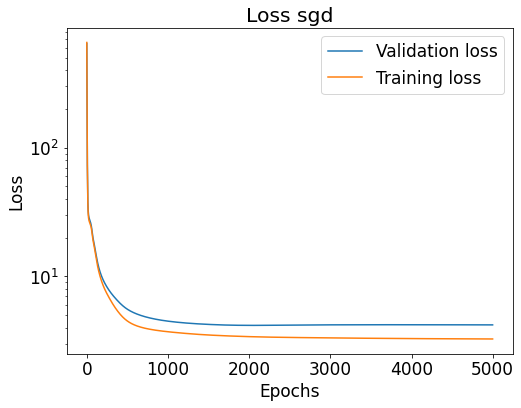

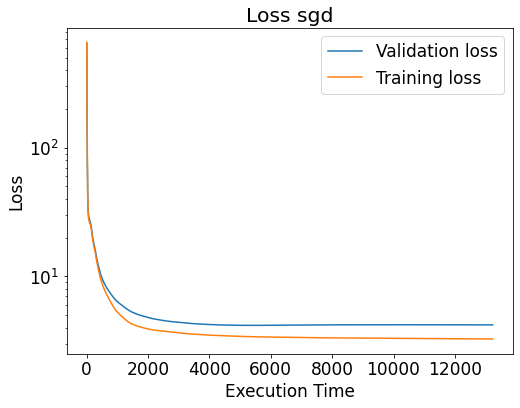

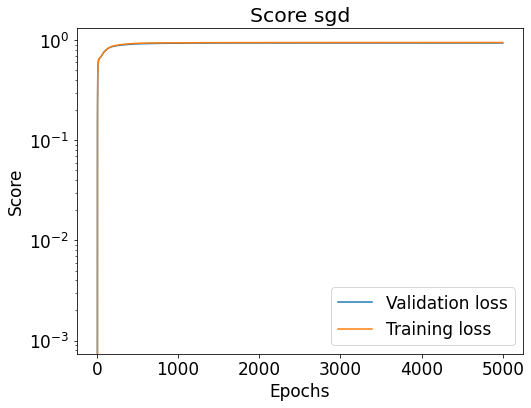

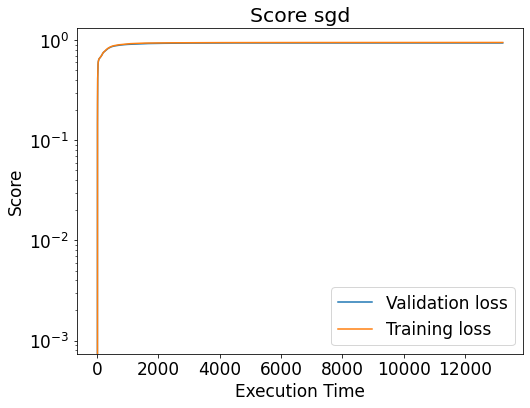

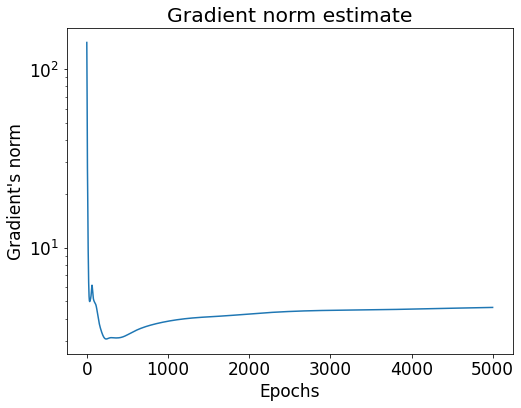

ep: 5000    | s: [5, 10] | b: 128 | e:0.001 | alpha:  0.2 | m:  0.5 | nesterovs_momentum: True
Grad: 7.07469e+00 | Loss: 4.16132e+00, 3.39729e+00 | Score: 0.939, 0.948
ended in: 13230.022, avg per ep: 2.6460044000000003
total update: 8778.969000000014, avg updt: 1.7557938000000028
total ff: 55000, total ff time: 3415.7770000007577, avg ff: 0.06210503636365014
total bp: 45000, total bp time: 4096.988999999987, avg bp: 0.09104419999999971
total ev: 5000, total ev time: 4309.9249999999965, avg ev: 0.8619849999999993


----- SGD NAG -----
{'activation': 'logistic', 'alpha': 0.2, 'batch_size': 128, 'hidden_layer_sizes': [5, 10], 'learning_rate_init': 0.001, 'max_iter': 5000, 'momentum': 0.5, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1e-08}


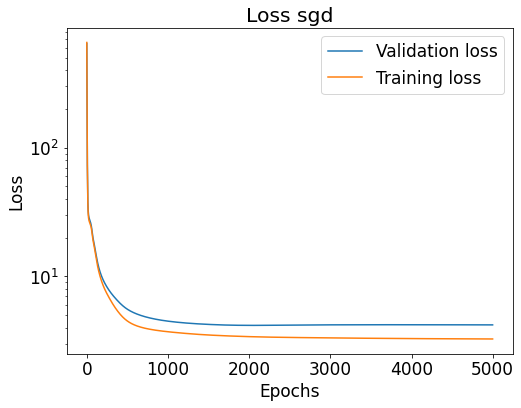

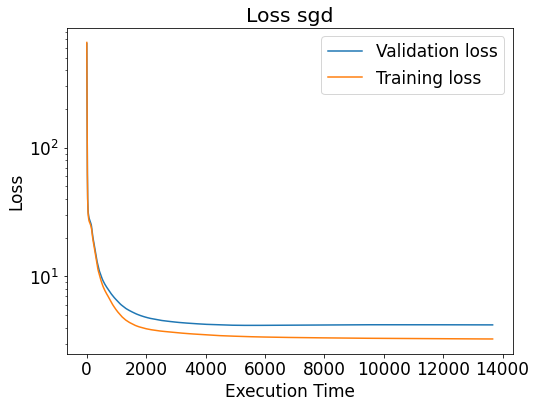

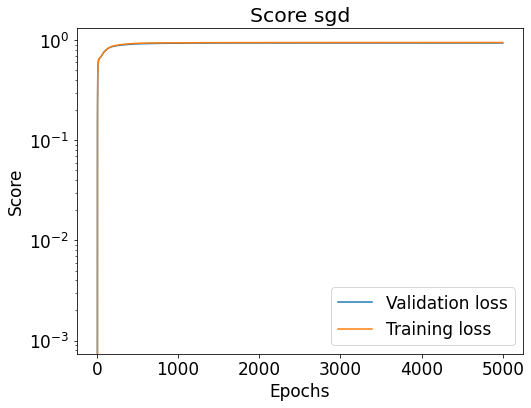

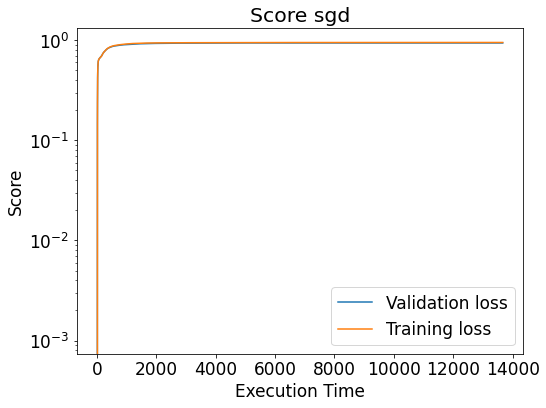

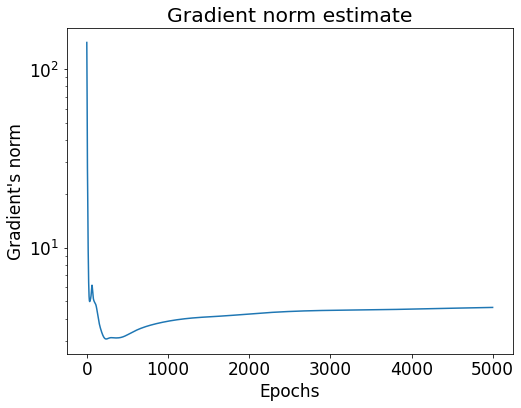

ep: 5000    | s: [5, 10] | b: 128 | e:0.001 | alpha:  0.2 | m:  0.5 | nesterovs_momentum: True
Grad: 7.07469e+00 | Loss: 4.16132e+00, 3.39729e+00 | Score: 0.939, 0.948
ended in: 13664.996, avg per ep: 2.7329991999999996
total update: 9022.920000000036, avg updt: 1.8045840000000073
total ff: 55000, total ff time: 3527.345000000563, avg ff: 0.06413354545455568
total bp: 45000, total bp time: 4202.846000000081, avg bp: 0.09339657777777959
total ev: 5000, total ev time: 4489.858000000003, avg ev: 0.8979716000000005


----- Adam -----
{'activation': 'logistic', 'alpha': 0.2, 'batch_size': 128, 'hidden_layer_sizes': [5, 10], 'learning_rate_init': 0.001, 'max_iter': 5000, 'solver': 'adam', 'tol': 1e-08}


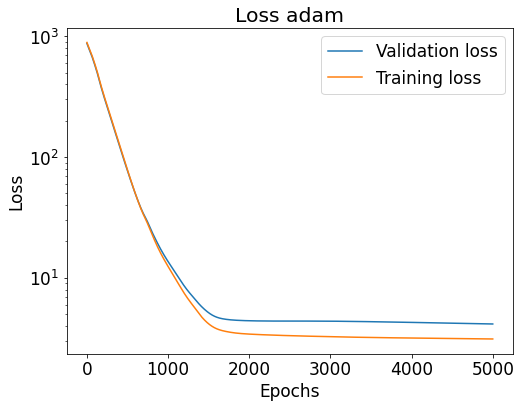

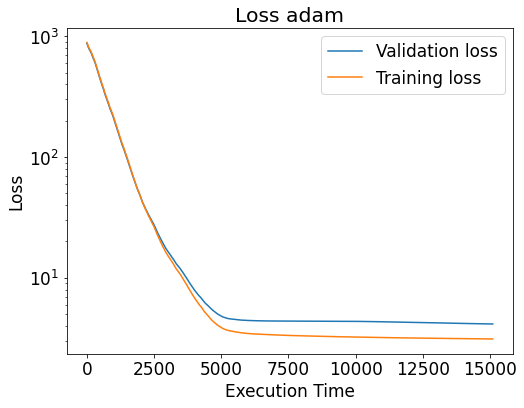

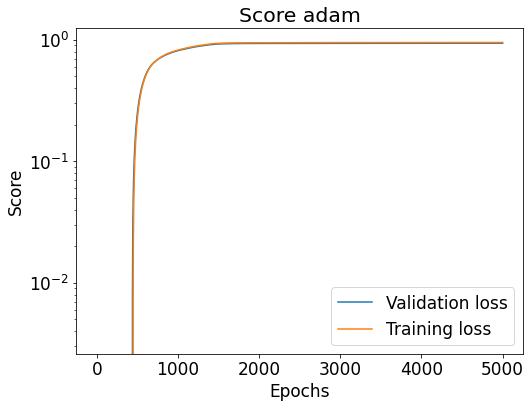

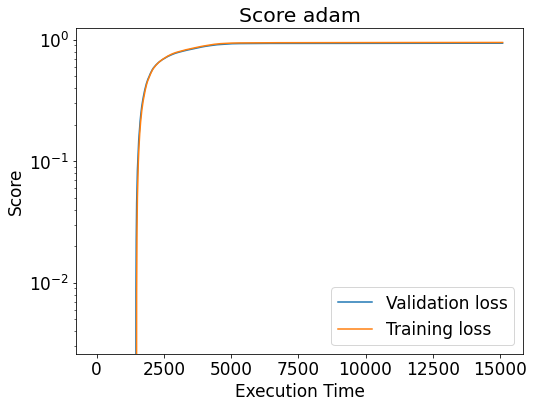

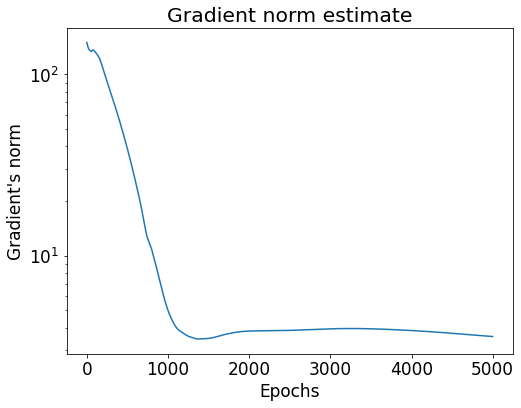

ep: 5000    | s: [5, 10] | b: 128 | e:0.001 | alpha:  0.2 | m:  0.5 | nesterovs_momentum: False
Grad: 5.70115e+00 | Loss: 4.14961e+00, 3.11830e+00 | Score: 0.939, 0.952
ended in: 15099.19, avg per ep: 3.019838
total update: 10433.73400000001, avg updt: 2.086746800000002
total ff: 55000, total ff time: 3530.243000000984, avg ff: 0.06418623636365425
total bp: 45000, total bp time: 4219.737000000212, avg bp: 0.09377193333333804
total ev: 5000, total ev time: 4509.113999999997, avg ev: 0.9018227999999994




<Figure size 576x432 with 0 Axes>

In [ ]:
print("----- SGD CM -----")
plot_stats(sgd_cm, dataset, 'SGD', net_SGD)
print("----- SGD NAG -----")
plot_stats(sgd_nag, dataset, 'SGD', net_SGD_nest)
print("----- Adam -----")
plot_stats(adam, dataset, 'Adam', net_Adam)

# Report stats

In [6]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': (8, 6)})

## Monk1

In [24]:
debug = False
score = False
dataset = 'monk1'
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=score, debug=debug)

/home/luca/Desktop/CM/CM/src/NN/Network.py:499: RuntimeWarning: divide by zero encountered in double_scalars
  self.grad_rate.append(self.grad_gap[-1]/self.grad_gap[-2])


----- SGD -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.005, 'max_iter': 10000, 'momentum': 0.9, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06, 'verbose': False}
ep: 10000   | s: [3, 5] | b: 10 | e:0.005 | alpha:0.001 | m:  0.9 | nesterovs_momentum: False
Grad: 4.99626e-03 | Loss: 1.07365e-03, 7.92179e-04 | Score:     1, 1    
ended in: 20487.112, avg per ep: 2.0487112
total update: 17251.141999999985, avg updt: 0.14375951666666653
total ff: 150000, total ff time: 4200.756999999399, avg ff: 0.02800504666666266
total bp: 130000, total bp time: 8028.358000001366, avg bp: 0.06175660000001051
total ev: 10000, total ev time: 2927.994000000015, avg ev: 0.29279940000000154

 

----- SGD nesterov-----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.005, 'max_iter': 10000, 'momentum': 0.9, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1

### Loss comparison

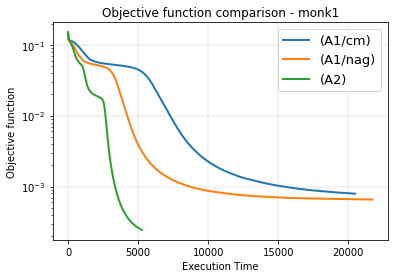

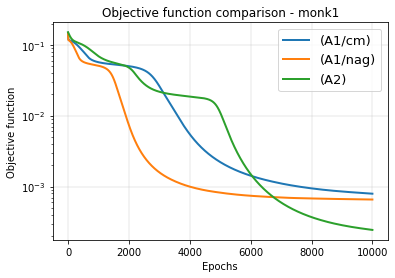

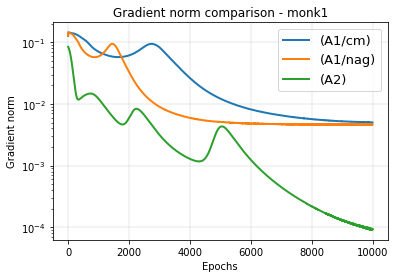

<Figure size 432x288 with 0 Axes>

In [25]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=score)

### Rate and gap comparison

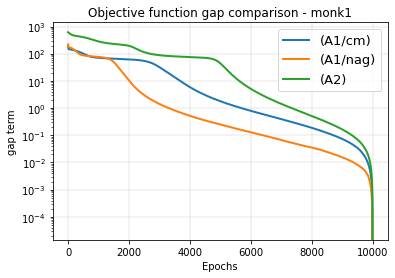

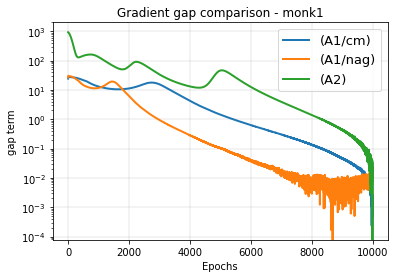

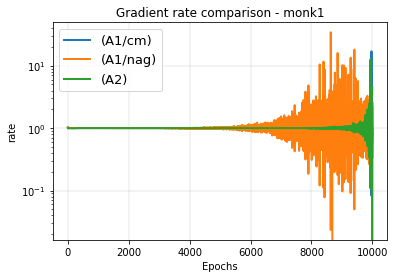

<Figure size 432x288 with 0 Axes>

In [26]:
report_gap_comp(dataset, net_SGD, net_SGD_nest, net_Adam, save=False)

## Monk2

In [31]:
debug = False
score = False
dataset = 'monk2'
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=score, debug=debug)

/home/luca/Desktop/CM/CM/src/NN/Network.py:499: RuntimeWarning: divide by zero encountered in double_scalars
  self.grad_rate.append(self.grad_gap[-1]/self.grad_gap[-2])


----- SGD -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06, 'verbose': False}
ep: 10000   | s: [3, 5] | b: 10 | e:  0.1 | alpha:0.001 | m:  0.5 | nesterovs_momentum: False
Grad: 2.54680e-03 | Loss: 5.74354e-04, 4.97920e-04 | Score:     1, 1    
ended in: 25603.303, avg per ep: 2.5603303
total update: 22321.05400000002, avg updt: 0.1395065875000001
total ff: 190000, total ff time: 5082.623000003588, avg ff: 0.026750647368439934
total bp: 170000, total bp time: 10445.057000007848, avg bp: 0.061441511764752044
total ev: 10000, total ev time: 2972.592999999974, avg ev: 0.2972592999999974

 

----- SGD nesterov-----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1e-06

### Loss comparison

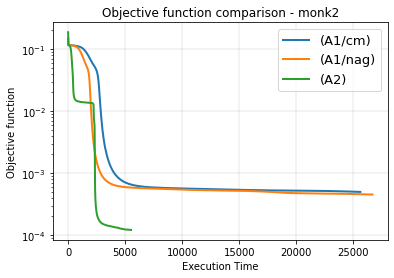

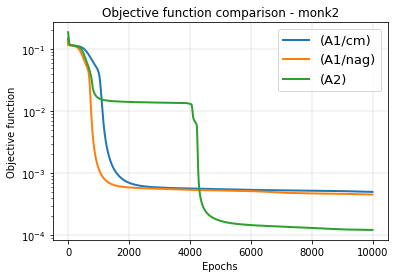

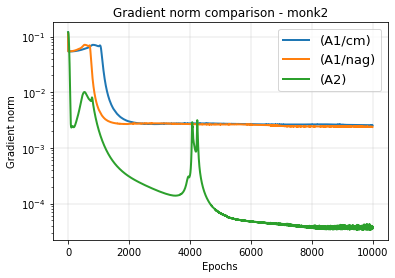

<Figure size 432x288 with 0 Axes>

In [32]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=score)

### Rate and gap comparison

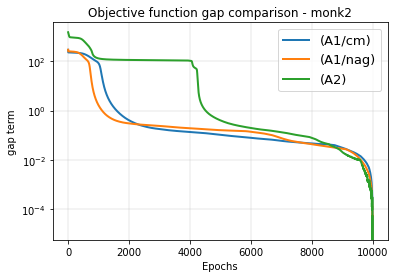

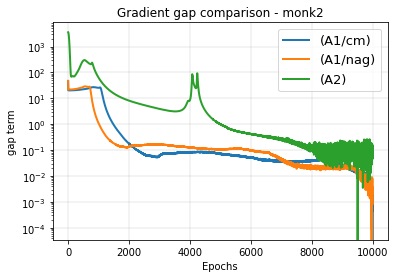

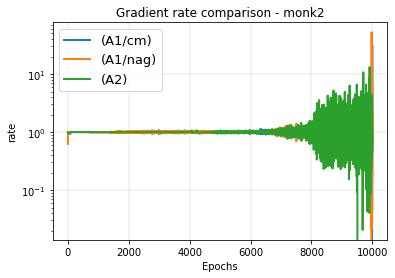

<Figure size 432x288 with 0 Axes>

In [33]:
report_gap_comp(dataset, net_SGD, net_SGD_nest, net_Adam, save=False)

## Monk3

In [16]:
debug = False
score = False
dataset = 'monk3'
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=score, debug=debug)

c:\Users\ulfhe\Documents\GitHub\CM\src\NN\Network.py:499: RuntimeWarning: divide by zero encountered in double_scalars
  self.grad_rate.append(self.grad_gap[-1]/self.grad_gap[-2])


----- SGD -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': None, 'hidden_layer_sizes': [2, 3], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06, 'verbose': False}
ep: 10000   | s: [2, 3] | b: 122 | e:  0.1 | alpha:0.001 | m:  0.5 | nesterovs_momentum: False
Grad: 1.26598e-03 | Loss: 2.19077e-02, 2.83878e-02 | Score: 0.972, 0.934
ended in: 4621.027, avg per ep: 0.4621027
total update: 1871.1770000000015, avg updt: 0.18711770000000014
total ff: 30000, total ff time: 1396.8419999999996, avg ff: 0.04656139999999999
total bp: 10000, total bp time: 938.265000000001, avg bp: 0.0938265000000001
total ev: 10000, total ev time: 2530.017999999995, avg ev: 0.2530017999999995

 

----- SGD nesterov-----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': None, 'hidden_layer_sizes': [2, 3], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1e-06

### Loss comparison

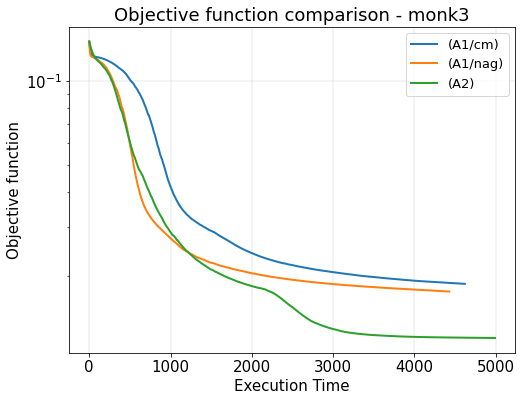

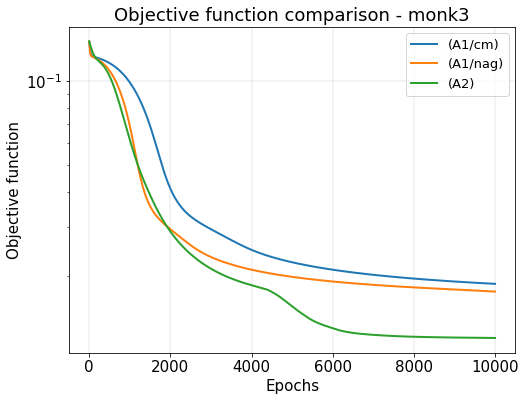

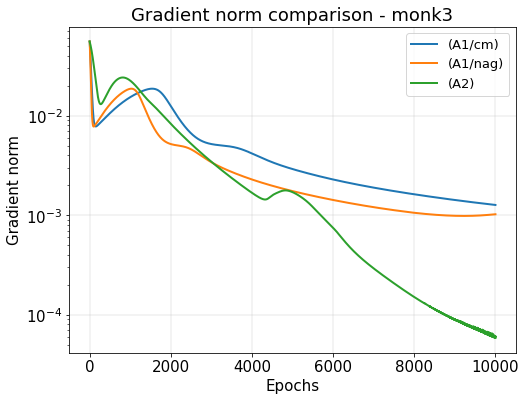

<Figure size 576x432 with 0 Axes>

In [17]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=score)

### Rate and gap comparison

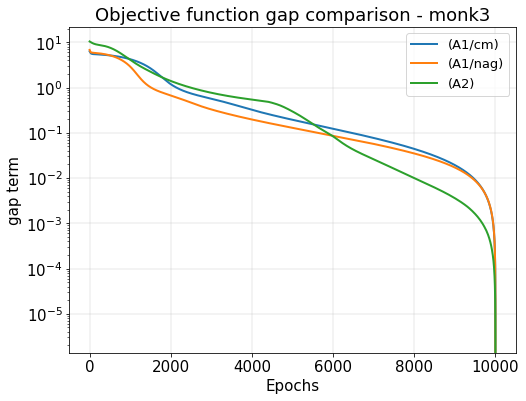

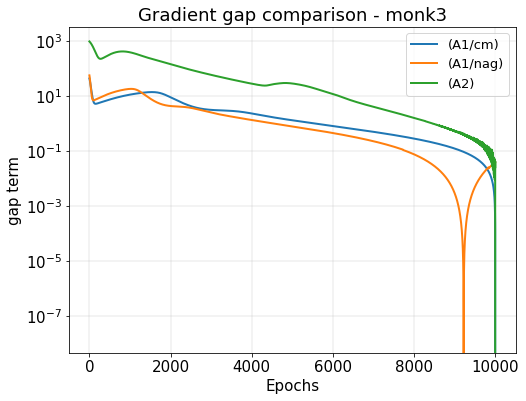

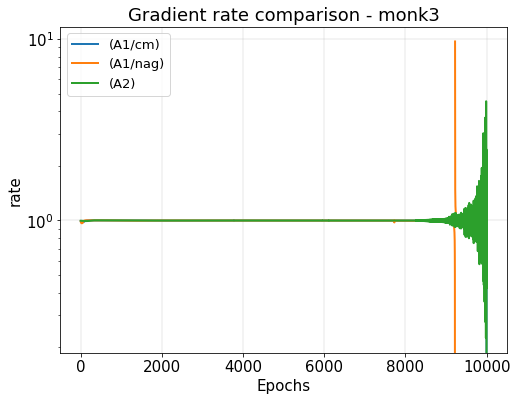

<Figure size 576x432 with 0 Axes>

In [18]:
report_gap_comp(dataset, net_SGD, net_SGD_nest, net_Adam, save=False)

## CUP

In [18]:
debug = False
score = False
dataset = 'cup'
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=score, debug=debug)

----- SGD -----
{'activation': 'logistic', 'alpha': 0.3, 'batch_size': None, 'hidden_layer_sizes': [5, 10], 'learning_rate_init': 0.01, 'max_iter': 10000, 'momentum': 0.5, 'solver': 'sgd', 'tol': 1e-08, 'verbose': False}
ep: 10000   | s: [5, 10] | b: 1033 | e: 0.01 | alpha:  0.3 | m:  0.5 | nesterovs_momentum: False
Grad: 1.52774e-02 | Loss: 5.77415e-01, 5.04001e-01 | Score: 0.933, 0.943
ended in: 19394.794, avg per ep: 1.9394794000000002
total update: 7498.328999999969, avg updt: 0.7498328999999969
total ff: 30000, total ff time: 6415.759999999858, avg ff: 0.21385866666666195
total bp: 10000, total bp time: 4114.845999999968, avg bp: 0.41148459999999676
total ev: 10000, total ev time: 11502.044999999984, avg ev: 1.1502044999999983

 

----- SGD nesterov-----
{'activation': 'logistic', 'alpha': 0.3, 'batch_size': None, 'hidden_layer_sizes': [5, 10], 'learning_rate_init': 0.01, 'max_iter': 10000, 'momentum': 0.5, 'solver': 'sgd', 'tol': 1e-08, 'verbose': False, 'nesterovs_momentum': Tru

/home/luca/Desktop/CM/CM/src/NN/Network.py:499: RuntimeWarning: divide by zero encountered in double_scalars
  self.grad_rate.append(self.grad_gap[-1]/self.grad_gap[-2])


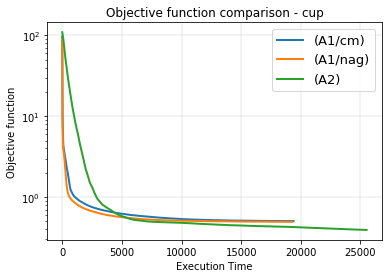

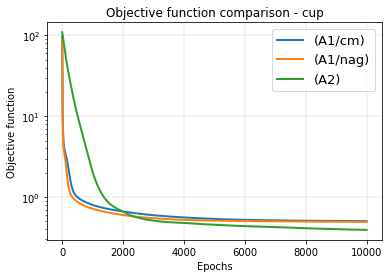

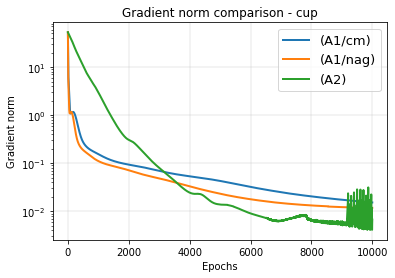

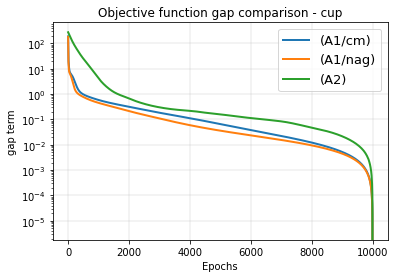

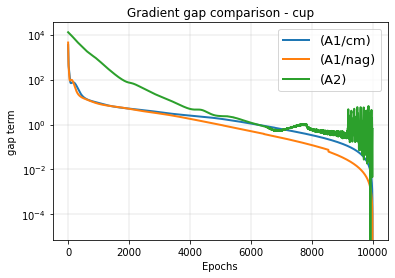

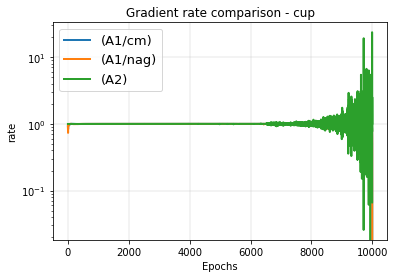

<Figure size 432x288 with 0 Axes>

In [19]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=score)
report_gap_comp(dataset, net_SGD, net_SGD_nest, net_Adam, save=False)

# Test convergence to given precision (OLD)

In [ ]:
params_conv = params.copy()

### Monk1

In [ ]:
debug = False
score = False
dataset = 'monk1'

epochs = 10000
eps = 1e-7

sgd_cm = params[dataset]['sgd'].copy()
sgd_cm['learning_rate_init'] = 0.8
sgd_cm['max_iter'] = epochs
sgd_cm['tol'] = eps
sgd_cm['alpha'] = 0

sgd_nag = sgd_cm.copy()
sgd_cm['learning_rate_init'] = 0.8
sgd_cm['max_iter'] = epochs
sgd_cm['tol'] = eps
sgd_cm['alpha'] = 0
sgd_nag['nesterovs_momentum'] = True

adam = params[dataset]['adam'].copy()
adam['max_iter'] = epochs
adam['tol'] = eps
adam['alpha'] = 0

monk1 = {
    'sgd': sgd_cm,
    'sgd_nest': sgd_nag,
    'adam': adam
}

net_cm, net_nag, net_adam = convergence_test(dataset, monk1)

Reached desired precision in gradient norm,stopping.


{'activation': 'logistic', 'alpha': 0, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.8, 'max_iter': 10000, 'momentum': 0.8, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 0.001}


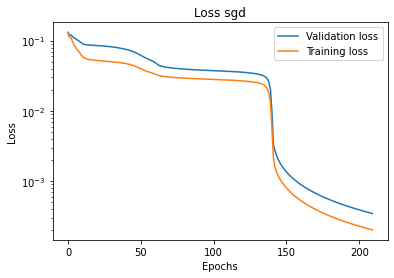

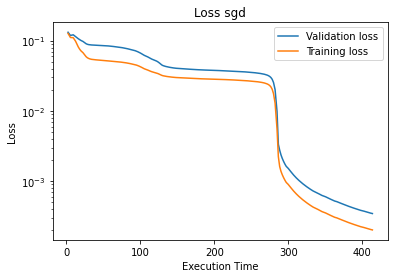

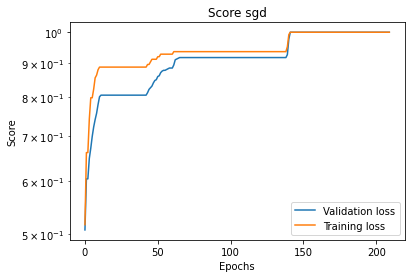

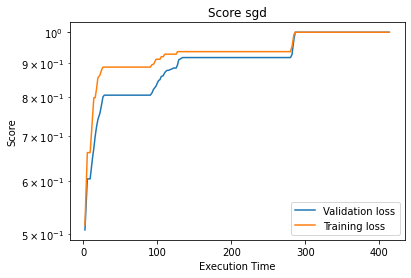

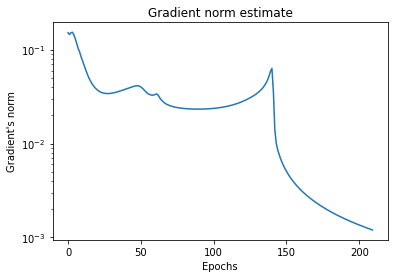

ep: 10000   | s: [3, 5] | b: 10 | e:  0.8 | alpha:    0 | m:  0.8 | nesterovs_momentum: False
Grad: 9.99562e-04 | Loss: 3.46268e-04, 2.02415e-04 | Score:     1, 1    
ended in: 413.836, avg per ep: 0.0413836
total update: 357.2259999999999, avg updt: 0.035722599999999986
total ff: 3150, total ff time: 88.94400000000137, avg ff: 0.02823619047619091
total bp: 2730, total bp time: 167.02000000000106, avg bp: 0.06117948717948757
total ev: 210, total ev time: 51.47800000000005, avg ev: 0.24513333333333356


{'activation': 'logistic', 'alpha': 0, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.8, 'max_iter': 10000, 'momentum': 0.8, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 0.001}


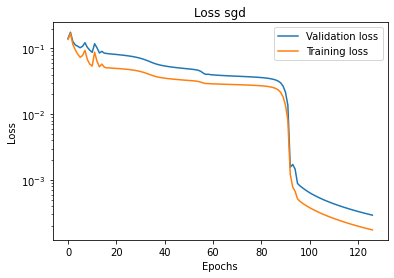

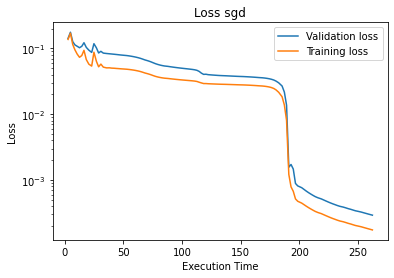

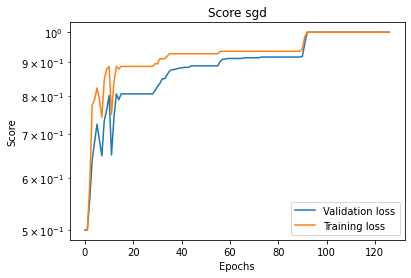

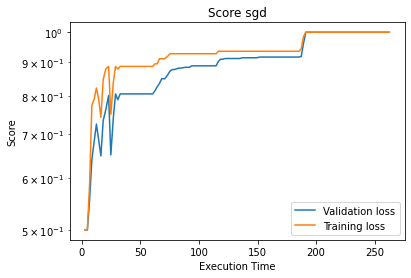

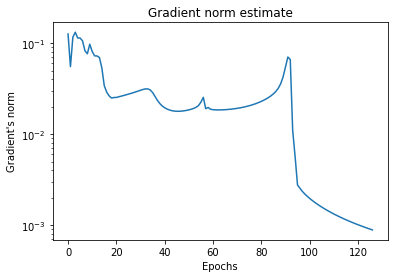

ep: 10000   | s: [3, 5] | b: 10 | e:  0.8 | alpha:    0 | m:  0.8 | nesterovs_momentum: True
Grad: 9.97542e-04 | Loss: 2.91248e-04, 1.73723e-04 | Score:     1, 1    
ended in: 262.433, avg per ep: 0.0262433
total update: 228.49699999999996, avg updt: 0.022849699999999997
total ff: 1905, total ff time: 52.72600000000035, avg ff: 0.027677690288714092
total bp: 1651, total bp time: 99.70300000000127, avg bp: 0.060389460932768785
total ev: 127, total ev time: 30.858999999999998, avg ev: 0.24298425196850393


{'activation': 'logistic', 'alpha': 0, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.1, 'max_iter': 10000, 'solver': 'adam', 'tol': 0.001}


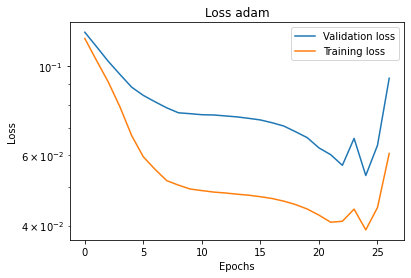

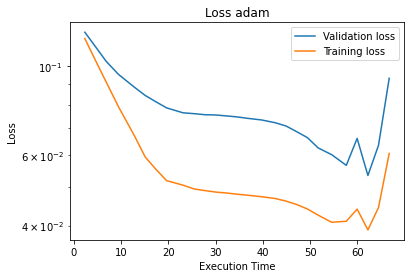

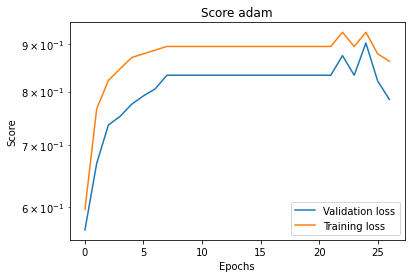

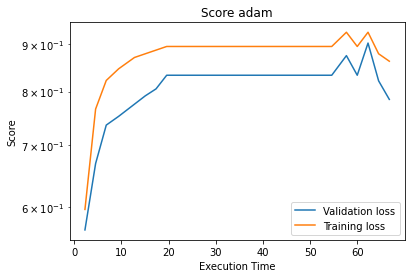

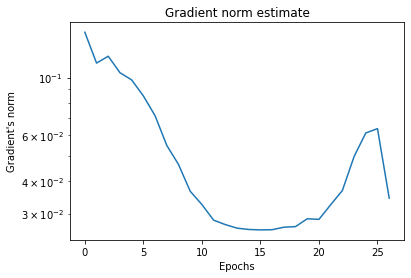

ep: 10000   | s: [3, 5] | b: 10 | e:  0.1 | alpha:    0 | m:  0.5 | nesterovs_momentum: False
Grad: 7.74079e-04 | Loss: 5.33598e-02, 3.90467e-02 | Score: 0.903, 0.927
ended in: 66.749, avg per ep: 0.006674899999999999
total update: 59.42699999999999, avg updt: 0.0059426999999999995
total ff: 405, total ff time: 11.553000000000031, avg ff: 0.028525925925926003
total bp: 351, total bp time: 21.36299999999995, avg bp: 0.06086324786324772
total ev: 27, total ev time: 6.624000000000001, avg ev: 0.24533333333333338




<Figure size 432x288 with 0 Axes>

In [ ]:
plot_stats(sgd_cm, dataset=dataset, test='SGD', net=net_cm, log=True)
plot_stats(sgd_nag, dataset=dataset, test='SGD', net=net_nag, log=True)
plot_stats(adam, dataset=dataset, test='Adam', net=net_adam, log=True)

----- SGD -----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.01, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}
ep: 10000   | s: [16, 32] | b: 124 | e:  0.8 | lmbda:    0 | m:  0.5 | nesterov: False
Grad: 9.89515e-04 | Loss: 2.04178e-03, 2.43510e-04 | Score:     1, 1    
ended in: 555.067, avg per ep: 0.0555067
total update: 143.865, avg updt: 0.014386500000000002
total ff: 870, total ff time: 324.9559999999997, avg ff: 0.37351264367816056
total bp: 290, total bp time: 60.083000000000084, avg bp: 0.20718275862068994
total ev: 290, total ev time: 397.04600000000005, avg ev: 1.3691241379310346

 

----- SGD nesterov-----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.01, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}
ep: 10000   | s: [16, 32] | b: 124 | e:  0.8 | lmbda:    0 | m:  0.5 | nesterov: True
Grad: 9.91275e-04 | Loss: 2.19657e-03, 2.45705e-04 | Score:     1, 1    
ended in: 33

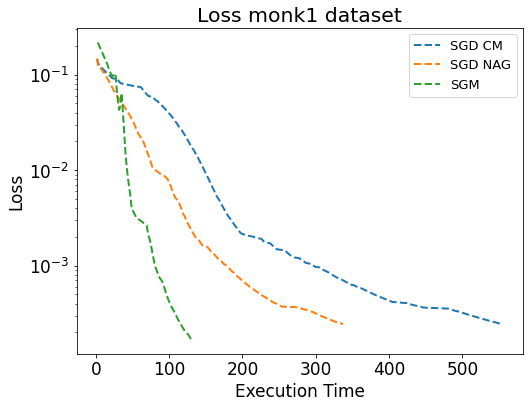

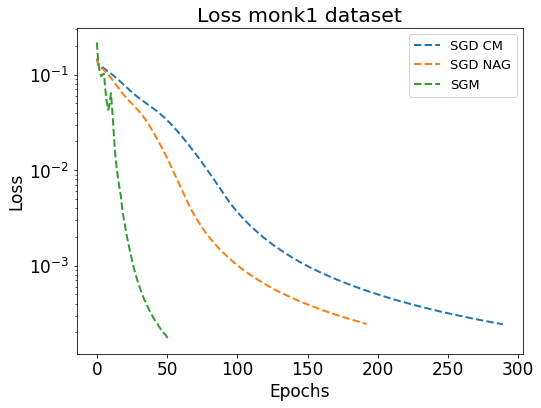

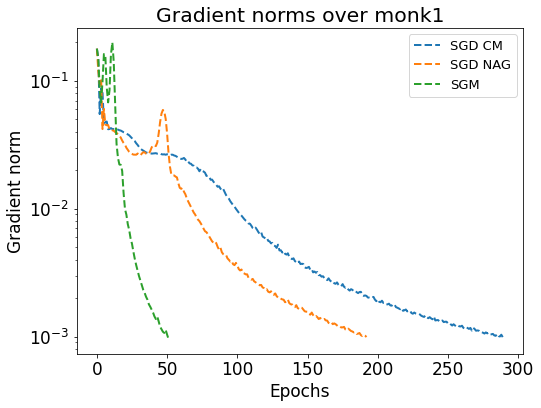

<Figure size 576x432 with 0 Axes>

In [ ]:
report_plots(params_conv, dataset, net_SGD=net_cm, net_SGD_nest=net_nag, net_Adam=net_adam, score=score)

### Monk2

In [ ]:
debug = False
score = False
dataset = 'monk2'

epochs = 10000
eps = 1e-3

sgd_cm = params[dataset]['SGD'].copy()
sgd_cm['eta'] = 0.8
sgd_cm['epochs'] = epochs
sgd_cm['eps'] = eps

sgd_nag = sgd_cm.copy()
sgd_nag['eta'] = 0.8
sgd_nag['nesterov'] = True
sgd_nag['epochs'] = epochs
sgd_nag['eps'] = eps

adam = params[dataset]['Adam'].copy()
adam['epochs'] = epochs
adam['eps'] = eps

monk2 = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}

net_cm, net_nag, net_adam = convergence_test(dataset, monk2)

1       || Gradient norm: 2.60753e-01 || Loss: 1.61126e-01, 1.51250e-01 || Score: 0.331, 0.385
2       || Gradient norm: 2.24112e-01 || Loss: 1.13211e-01, 1.17949e-01 || Score: 0.667, 0.615
3       || Gradient norm: 1.90443e-02 || Loss: 1.12912e-01, 1.23931e-01 || Score: 0.671, 0.621
4       || Gradient norm: 8.89743e-02 || Loss: 1.12471e-01, 1.23121e-01 || Score: 0.671, 0.621
5       || Gradient norm: 8.60818e-02 || Loss: 1.10779e-01, 1.18107e-01 || Score: 0.671, 0.621
6       || Gradient norm: 4.81954e-02 || Loss: 1.12369e-01, 1.16151e-01 || Score: 0.671, 0.627
7       || Gradient norm: 1.77854e-02 || Loss: 1.14129e-01, 1.16185e-01 || Score: 0.639, 0.58 
8       || Gradient norm: 3.22172e-02 || Loss: 1.13415e-01, 1.15581e-01 || Score:  0.65, 0.592
9       || Gradient norm: 2.81358e-02 || Loss: 1.11837e-01, 1.14843e-01 || Score: 0.671, 0.627
10      || Gradient norm: 1.73785e-02 || Loss: 1.10819e-01, 1.14427e-01 || Score: 0.669, 0.621
11      || Gradient norm: 1.66071e-02 || Loss: 1.1

{'batch_size': None, 'epochs': 10000, 'eps': 0.001, 'eta': 0.8, 'lmbda': 0.0, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}


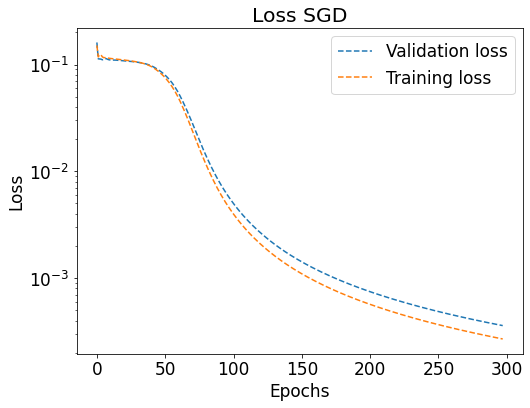

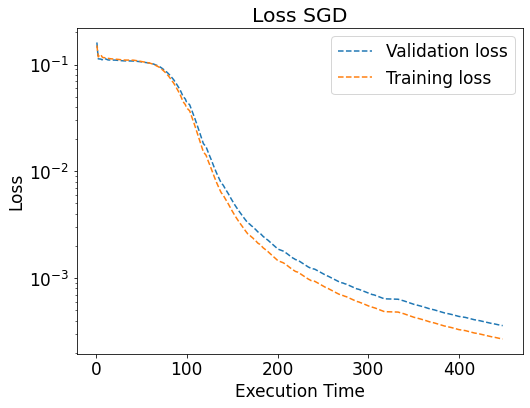

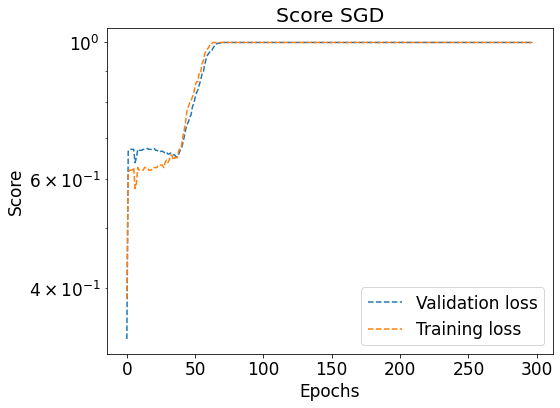

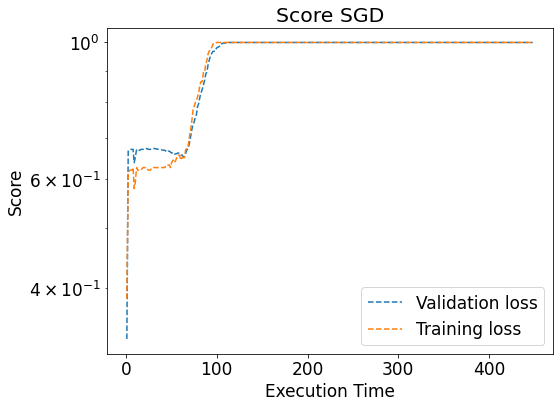

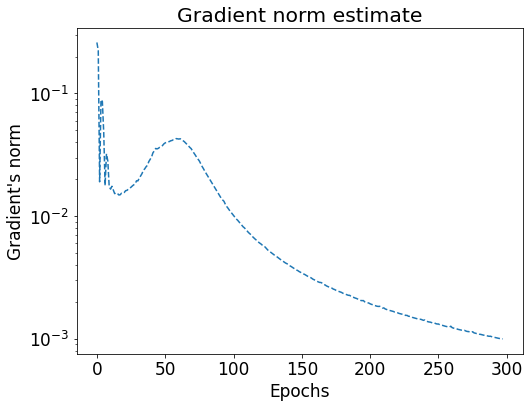

ep: 10000   | s: [16, 32] | b: 169 | e:  0.8 | lmbda:  0.0 | m:  0.5 | nesterov: False
Grad: 9.95147e-04 | Loss: 3.58341e-04, 2.68525e-04 | Score:     1, 1    
ended in: 448.131, avg per ep: 0.044813099999999995
total update: 146.78899999999987, avg updt: 0.014678899999999988
total ff: 894, total ff time: 232.2639999999996, avg ff: 0.25980313199105104
total bp: 298, total bp time: 63.68600000000012, avg bp: 0.21371140939597355
total ev: 298, total ev time: 288.57599999999974, avg ev: 0.9683758389261736


{'batch_size': None, 'epochs': 10000, 'eps': 0.001, 'eta': 0.8, 'lmbda': 0.0, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True, 'nesterov': True}


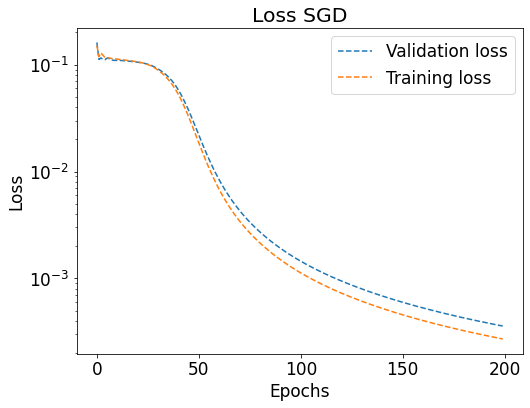

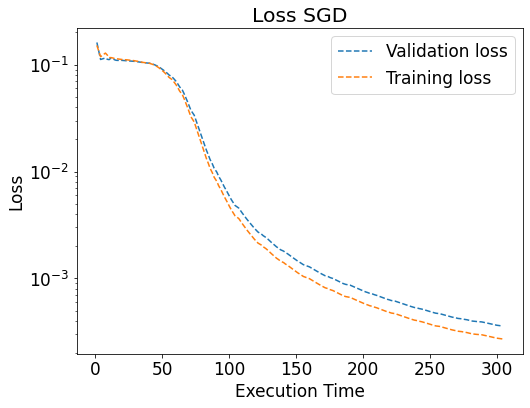

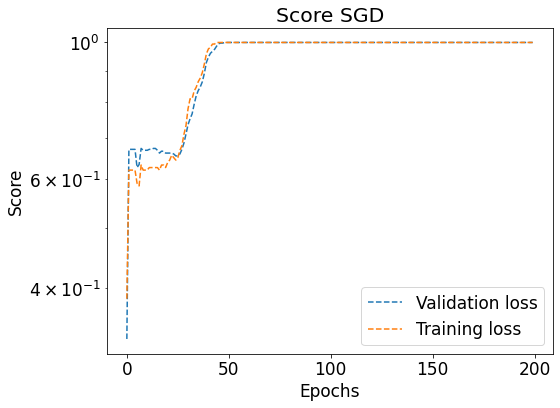

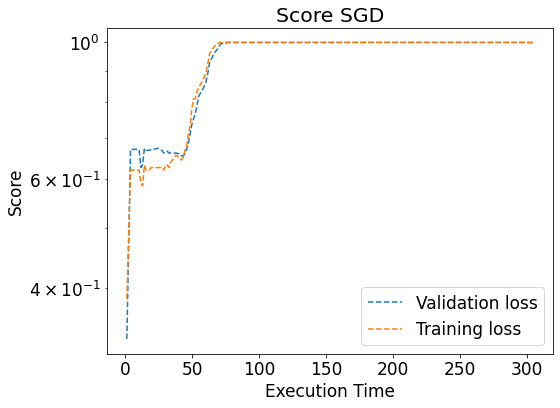

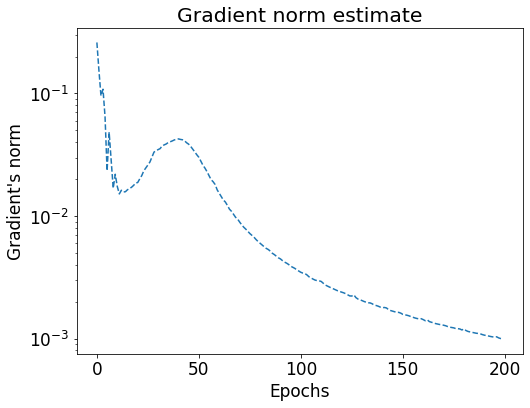

ep: 10000   | s: [16, 32] | b: 169 | e:  0.8 | lmbda:  0.0 | m:  0.5 | nesterov: True
Grad: 9.92151e-04 | Loss: 3.58321e-04, 2.71169e-04 | Score:     1, 1    
ended in: 304.442, avg per ep: 0.0304442
total update: 103.714, avg updt: 0.0103714
total ff: 600, total ff time: 154.026, avg ff: 0.25671
total bp: 200, total bp time: 42.87800000000007, avg bp: 0.21439000000000036
total ev: 200, total ev time: 192.48899999999998, avg ev: 0.9624449999999999


{'batch_size': None, 'epochs': 10000, 'eps': 0.001, 'eta': 0.1, 'lmbda': 0.0, 'optimizer': 'SGM', 'sizes': [16, 32], 'debug': True}


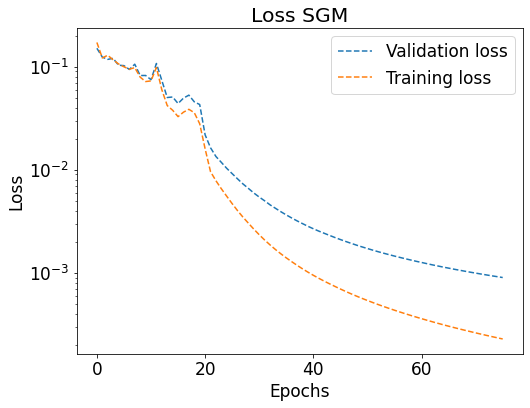

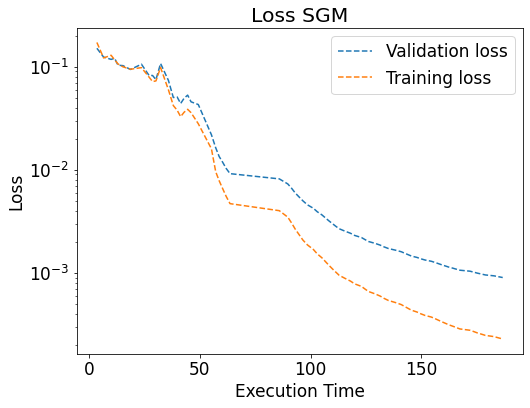

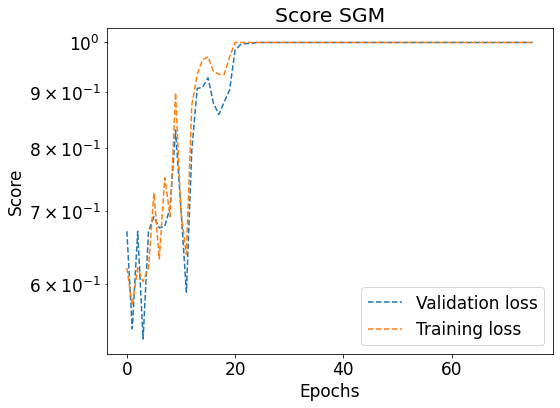

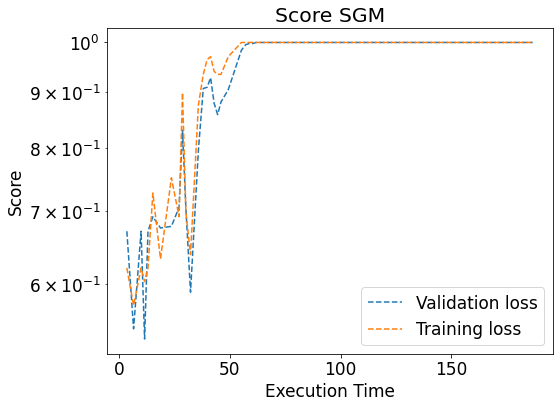

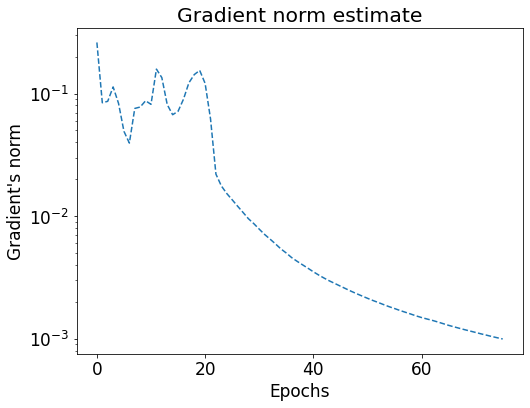

ep: 10000   | s: [16, 32] | b: 169 | e:  0.1 | lmbda:  0.0 | m:  0.5 | nesterov: False
Grad: 9.96110e-04 | Loss: 9.00407e-04, 2.28306e-04 | Score:     1, 1    
ended in: 186.918, avg per ep: 0.0186918
total update: 76.66600000000003, avg updt: 0.007666600000000003
total ff: 228, total ff time: 85.99800000000009, avg ff: 0.3771842105263162
total bp: 76, total bp time: 42.46700000000001, avg bp: 0.5587763157894738
total ev: 76, total ev time: 106.20399999999998, avg ev: 1.3974210526315787




<Figure size 576x432 with 0 Axes>

In [ ]:
plot_stats(sgd_cm, dataset=dataset, test='SGD', net=net_cm, log=True)
plot_stats(sgd_nag, dataset=dataset, test='SGD', net=net_nag, log=True)
plot_stats(adam, dataset=dataset, test='Adam', net=net_adam, log=True)

----- SGD -----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.0, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}
ep: 10000   | s: [16, 32] | b: 169 | e:  0.8 | lmbda:  0.0 | m:  0.5 | nesterov: False
Grad: 9.95147e-04 | Loss: 3.58341e-04, 2.68525e-04 | Score:     1, 1    
ended in: 448.131, avg per ep: 0.044813099999999995
total update: 146.78899999999987, avg updt: 0.014678899999999988
total ff: 894, total ff time: 232.2639999999996, avg ff: 0.25980313199105104
total bp: 298, total bp time: 63.68600000000012, avg bp: 0.21371140939597355
total ev: 298, total ev time: 288.57599999999974, avg ev: 0.9683758389261736

 

----- SGD nesterov-----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.0, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}
ep: 10000   | s: [16, 32] | b: 169 | e:  0.8 | lmbda:  0.0 | m:  0.5 | nesterov: True
Grad: 9.92151e-04 | Loss: 3.58321e-04, 2.71169e-04 | Score:     1,

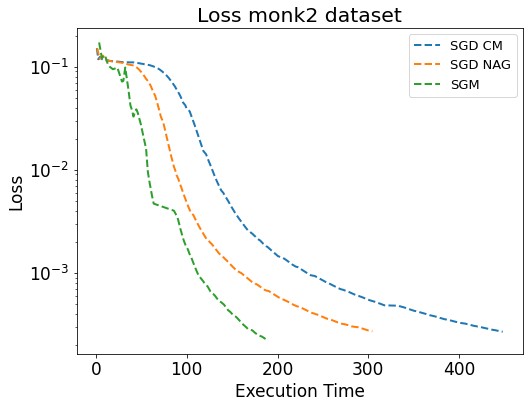

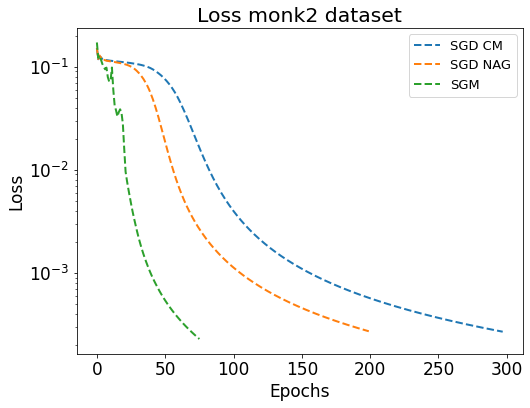

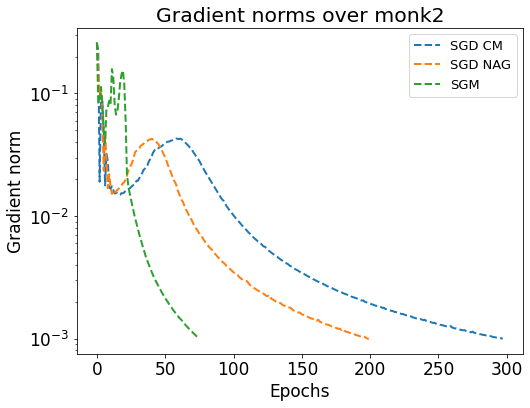

<Figure size 576x432 with 0 Axes>

In [ ]:
report_plots(params_conv, dataset, net_SGD=net_cm, net_SGD_nest=net_nag, net_Adam=net_adam, score=score)

### Monk3

In [ ]:
debug = False
score = False
dataset = 'monk3'

epochs = 10000
eps = 1e-3

sgd_cm = params[dataset]['SGD'].copy()
sgd_cm['eta'] = 0.8
sgd_cm['epochs'] = epochs
sgd_cm['eps'] = eps

sgd_nag = sgd_cm.copy()
sgd_nag['eta'] = 0.8
sgd_nag['nesterov'] = True
sgd_nag['epochs'] = epochs
sgd_nag['eps'] = eps

adam = params[dataset]['Adam'].copy()
adam['epochs'] = epochs
adam['eps'] = eps
adam['eta'] = 0.2

monk3 = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}


net_cm, net_nag, net_adam = convergence_test(dataset, monk3)

1       || Gradient norm: 1.01681e-01 || Loss: 1.44306e-01, 1.38888e-01 || Score: 0.472, 0.508
2       || Gradient norm: 8.66246e-02 || Loss: 1.35088e-01, 1.30617e-01 || Score: 0.472, 0.508
3       || Gradient norm: 6.67228e-02 || Loss: 1.28072e-01, 1.24487e-01 || Score: 0.472, 0.508
4       || Gradient norm: 4.93449e-02 || Loss: 1.23566e-01, 1.20772e-01 || Score: 0.472, 0.508
5       || Gradient norm: 3.76510e-02 || Loss: 1.20695e-01, 1.18524e-01 || Score: 0.521, 0.549
6       || Gradient norm: 3.20712e-02 || Loss: 1.18666e-01, 1.16898e-01 || Score: 0.637, 0.623
7       || Gradient norm: 3.24023e-02 || Loss: 1.16897e-01, 1.15329e-01 || Score: 0.669, 0.664
8       || Gradient norm: 3.41288e-02 || Loss: 1.15124e-01, 1.13630e-01 || Score: 0.692, 0.713
9       || Gradient norm: 3.52326e-02 || Loss: 1.13262e-01, 1.11727e-01 || Score: 0.697, 0.721
10      || Gradient norm: 3.74426e-02 || Loss: 1.11264e-01, 1.09583e-01 || Score: 0.711, 0.738
11      || Gradient norm: 3.88230e-02 || Loss: 1.0

{'batch_size': None, 'epochs': 10000, 'eps': 0.001, 'eta': 0.8, 'lmbda': 0.0001, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [5, 10], 'debug': True}


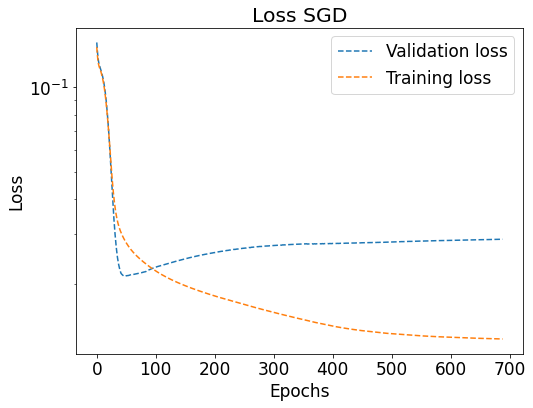

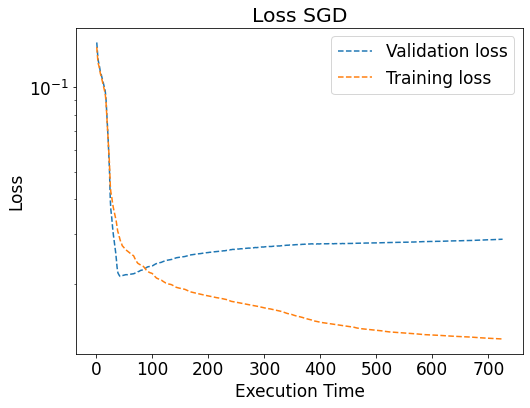

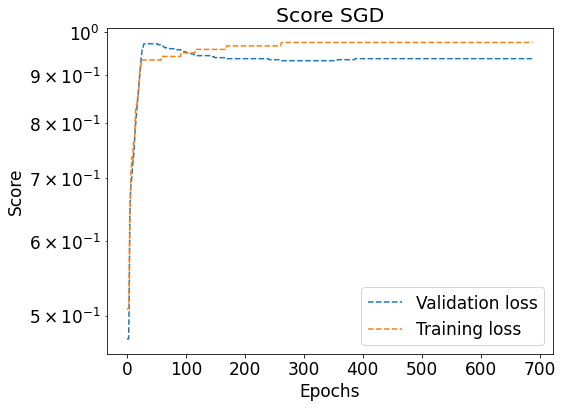

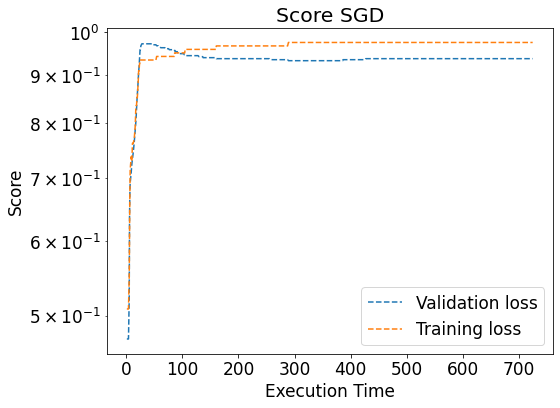

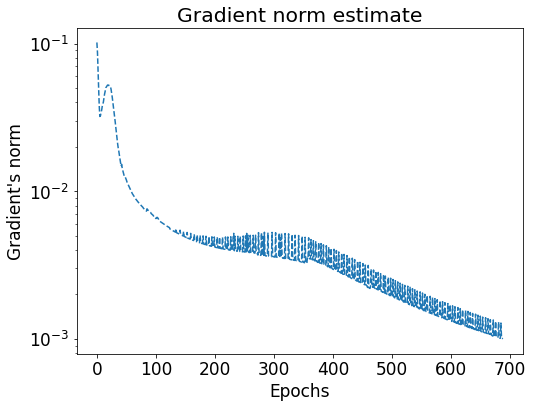

ep: 10000   | s: [5, 10] | b: 122 | e:  0.8 | lmbda:0.0001 | m:  0.5 | nesterov: False
Grad: 9.98609e-04 | Loss: 2.12720e-02, 2.87012e-02 | Score: 0.972, 0.934
ended in: 725.243, avg per ep: 0.0725243
total update: 391.8379999999996, avg updt: 0.03918379999999996
total ff: 2067, total ff time: 340.6369999999996, avg ff: 0.16479777455249134
total bp: 689, total bp time: 99.95500000000018, avg bp: 0.14507256894049372
total ev: 689, total ev time: 298.80599999999964, avg ev: 0.43368069666182824


{'batch_size': None, 'epochs': 10000, 'eps': 0.001, 'eta': 0.8, 'lmbda': 0.0001, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [5, 10], 'debug': True, 'nesterov': True}


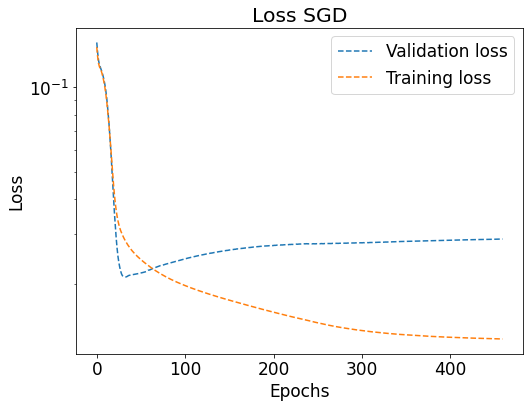

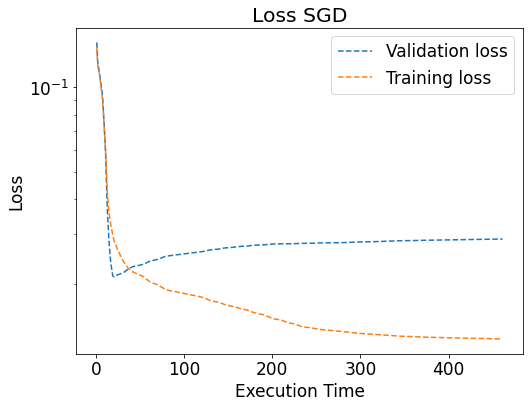

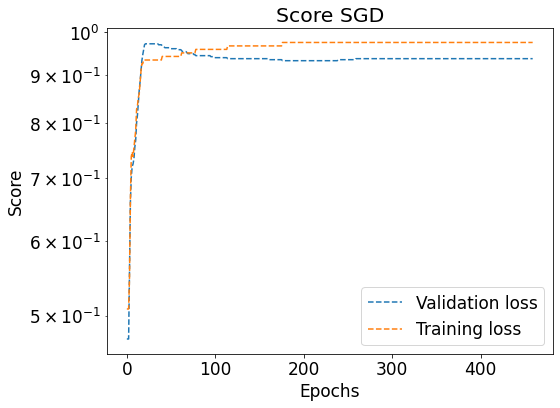

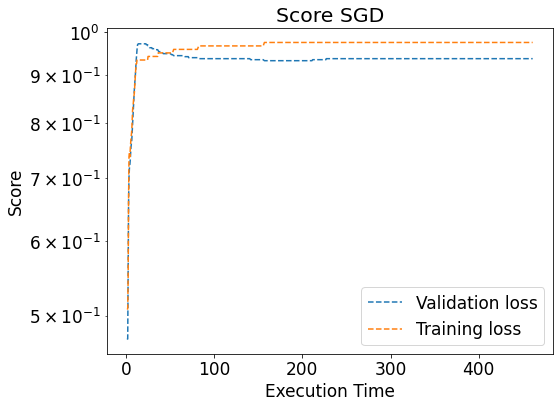

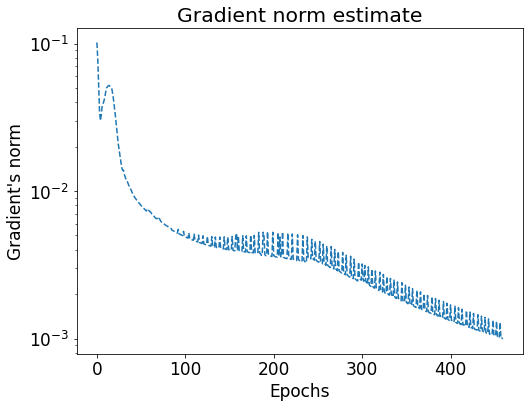

ep: 10000   | s: [5, 10] | b: 122 | e:  0.8 | lmbda:0.0001 | m:  0.5 | nesterov: True
Grad: 9.93390e-04 | Loss: 2.11754e-02, 2.82170e-02 | Score: 0.972, 0.934
ended in: 461.301, avg per ep: 0.0461301
total update: 257.52, avg updt: 0.025751999999999997
total ff: 1380, total ff time: 218.4300000000002, avg ff: 0.15828260869565233
total bp: 460, total bp time: 57.82099999999991, avg bp: 0.12569782608695634
total ev: 460, total ev time: 182.68899999999996, avg ev: 0.39714999999999995


{'batch_size': None, 'epochs': 10000, 'eps': 0.001, 'eta': 0.2, 'lmbda': 0.0001, 'optimizer': 'SGM', 'sizes': [5, 10], 'debug': True}


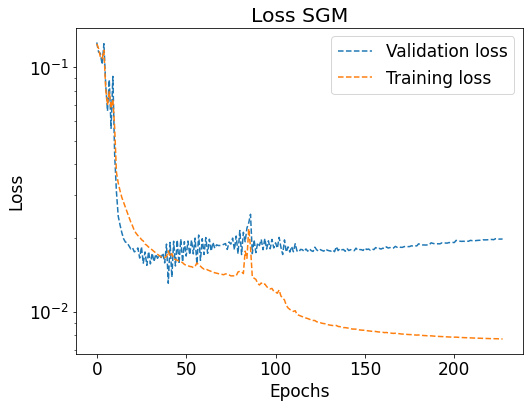

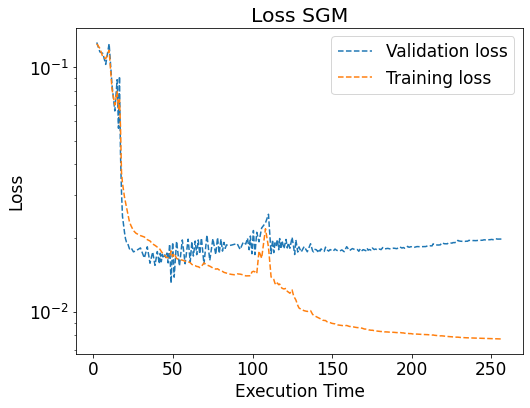

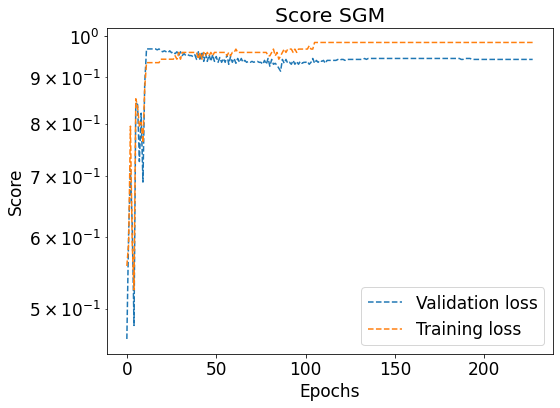

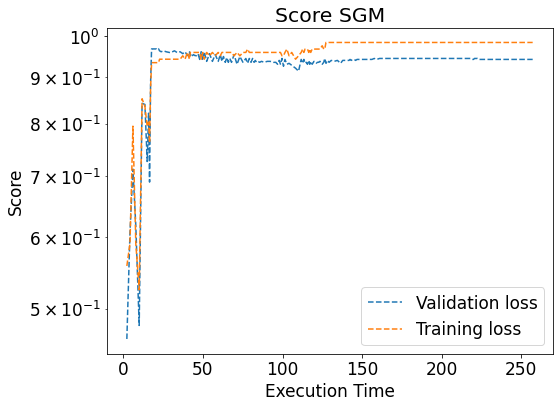

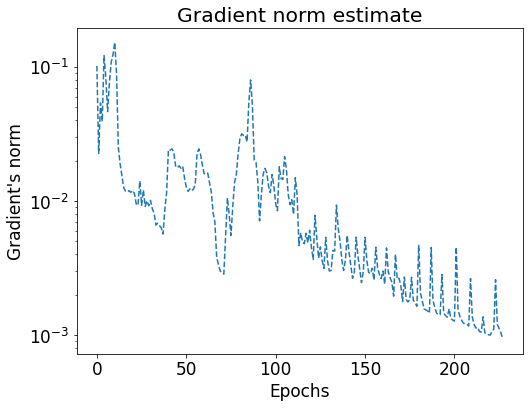

ep: 10000   | s: [5, 10] | b: 122 | e:  0.2 | lmbda:0.0001 | m:  0.5 | nesterov: False
Grad: 9.38087e-04 | Loss: 1.30780e-02, 1.77209e-02 | Score: 0.968, 0.934
ended in: 257.089, avg per ep: 0.0257089
total update: 164.49700000000004, avg updt: 0.016449700000000005
total ff: 684, total ff time: 99.09499999999987, avg ff: 0.14487573099415185
total bp: 228, total bp time: 72.32800000000002, avg bp: 0.3172280701754387
total ev: 228, total ev time: 82.92599999999996, avg ev: 0.3637105263157893




<Figure size 576x432 with 0 Axes>

In [ ]:
plot_stats(sgd_cm, dataset=dataset, test='SGD', net=net_cm, log=True)
plot_stats(sgd_nag, dataset=dataset, test='SGD', net=net_nag, log=True)
plot_stats(adam, dataset=dataset, test='Adam', net=net_adam, log=True)

----- SGD -----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.01, 'lmbda': 0.0001, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [5, 10], 'debug': True}
ep: 10000   | s: [5, 10] | b: 122 | e:  0.8 | lmbda:0.0001 | m:  0.5 | nesterov: False
Grad: 9.98609e-04 | Loss: 2.12720e-02, 2.87012e-02 | Score: 0.972, 0.934
ended in: 725.243, avg per ep: 0.0725243
total update: 391.8379999999996, avg updt: 0.03918379999999996
total ff: 2067, total ff time: 340.6369999999996, avg ff: 0.16479777455249134
total bp: 689, total bp time: 99.95500000000018, avg bp: 0.14507256894049372
total ev: 689, total ev time: 298.80599999999964, avg ev: 0.43368069666182824

 

----- SGD nesterov-----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.01, 'lmbda': 0.0001, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [5, 10], 'debug': True}
ep: 10000   | s: [5, 10] | b: 122 | e:  0.8 | lmbda:0.0001 | m:  0.5 | nesterov: True
Grad: 9.93390e-04 | Loss: 2.11754e-02, 2.82170e-02 | Score: 0.972, 0.93

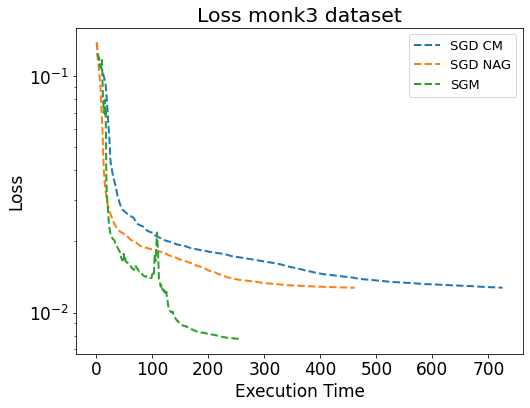

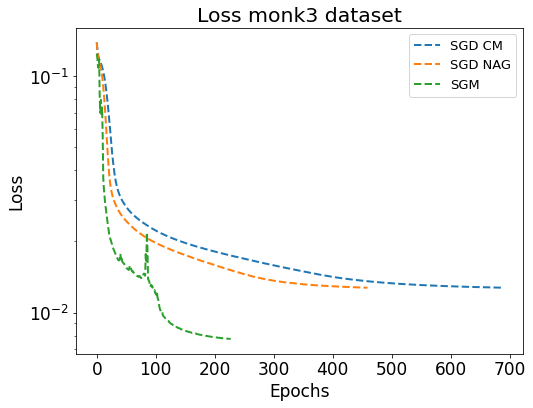

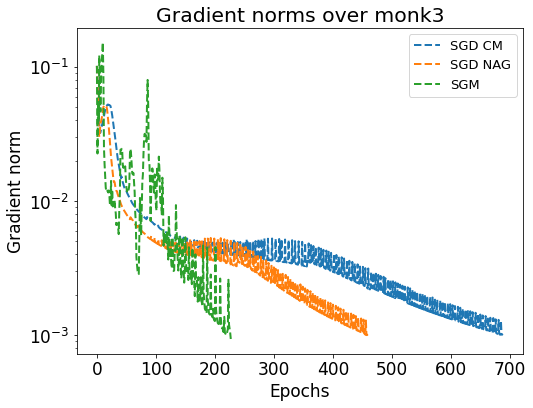

<Figure size 576x432 with 0 Axes>

In [ ]:
report_plots(params_conv, dataset, net_SGD=net_cm, net_SGD_nest=net_nag, net_Adam=net_adam, score=score)

### Cup

In [7]:
debug = False
score = False
dataset = 'cup'

epochs = 2000
eps = 5e-2

sgd_cm = params[dataset]['SGD'].copy()
sgd_cm['eta'] = 0.001
sgd_cm['epochs'] = epochs
sgd_cm['eps'] = eps

sgd_nag = sgd_cm.copy()
sgd_nag['eta'] = 0.001
sgd_nag['nesterov'] = True
sgd_nag['epochs'] = epochs
sgd_nag['eps'] = eps

adam = params[dataset]['Adam']
adam['epochs'] = epochs
adam['eps'] = eps
adam['eta'] = 0.2

cup = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}

net_cm, net_nag, net_adam = convergence_test(dataset, cup)

KeyError: 'SGD'

In [ ]:
plot_stats(sgd_cm, dataset=dataset, test='SGD', net=net_cm, log=True)
plot_stats(sgd_nag, dataset=dataset, test='SGD', net=net_nag, log=True)
plot_stats(adam, dataset=dataset, test='Adam', net=net_adam, log=True)

In [ ]:
report_plots(params_conv, dataset, net_SGD=net_cm, net_SGD_nest=net_nag, net_Adam=net_adam, score=score)